# 📊 Loan Approval Dataset – Objetivo do Projeto

## 🎯 Objetivo

O objetivo deste projeto é analisar um dataset de concessão de crédito com foco em **avaliação de risco financeiro** e na construção de um modelo preditivo para estimar o `loan_status`.

A proposta vai além da simples previsão. O foco está em compreender a lógica econômica por trás da decisão de crédito.

A análise buscará:

- Identificar quais variáveis mais influenciam o `loan_status`
- Entender o perfil demográfico e financeiro dos clientes
- Avaliar a relação entre renda, endividamento e histórico de crédito
- Detectar padrões comportamentais associados à inadimplência
- Investigar se as taxas de juros refletem adequadamente o nível de risco
- Construir e avaliar modelos de classificação

---

## 🏦 Contexto de Negócio

Instituições financeiras precisam equilibrar dois fatores centrais:

- 📉 Minimizar o risco de inadimplência  
- 📈 Maximizar o retorno ajustado ao risco  

Para isso, analisam variáveis como:

- Score de crédito  
- Histórico de inadimplência  
- Relação dívida/renda (DTI)  
- Nível de endividamento atual  
- Renda anual  

Neste projeto, o EDA será estruturado como um storytelling financeiro:

1. Perfil do cliente  
2. Qualidade de crédito  
3. Capacidade financeira  
4. Estrutura do empréstimo  
5. Sinais de alerta  
6. Relação das variáveis com o `loan_status`

### Nota importante sobre o alvo (`loan_status`)
Neste projeto, consideramos `loan_status=1` como **desfecho positivo** e `loan_status=0` como **desfecho negativo**.  
> (Ex.: aprovado / bom desfecho vs negado / mau desfecho — conforme a definição do dataset.)
Isso é relevante para interpretar corretamente métricas e a matriz de confusão:
- **Falso positivo (0→1)**: o modelo indica positivo quando era negativo (risco)
- **Falso negativo (1→0)**: o modelo indica negativo quando era positivo (oportunidade perdida)

---

# Importações

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import spearmanr, linregress


from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer


from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    f1_score, 
    accuracy_score,
    confusion_matrix, 
    classification_report,
    RocCurveDisplay
)


from sklearn.cluster import KMeans
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    classification_report, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score
)


HAS_XGB = True
try:
    from xgboost import XGBClassifier
except ImportError:
    HAS_XGB = False


# Dicionario de dados

In [2]:
loan_approval_features = {
    "age": "Idade do solicitante [anos]",
    "years_employed": "Tempo de emprego do solicitante [anos]",
    "annual_income": "Renda anual total do solicitante [USD]",
    "credit_score": "Pontuação de crédito do solicitante [score numérico]",
    "credit_history_years": "Tempo de histórico de crédito do solicitante [anos]",
    "savings_assets": "Total de ativos financeiros e economias do solicitante [USD]",
    "current_debt": "Valor total das dívidas atuais do solicitante [USD]",
    "defaults_on_file": "Número de inadimplências registradas no histórico de crédito",
    "delinquencies_last_2yrs": "Quantidade de atrasos ou inadimplências nos últimos 2 anos",
    "derogatory_marks": "Registros negativos no histórico de crédito (falências, cobranças judiciais, etc.)",
    "loan_amount": "Valor do empréstimo solicitado [USD]",
    "interest_rate": "Taxa de juros aplicada ao empréstimo [percentual anual - APR]",
    "debt_to_income_ratio": "Relação entre dívida total e renda anual do solicitante [percentual]",
    "loan_to_income_ratio": "Relação entre valor do empréstimo e renda anual [percentual]",
    "payment_to_income_ratio": "Relação entre valor da parcela do empréstimo e renda anual [percentual]",
    "loan_status": "Status do empréstimo ['Approved', 'Rejected', 'Fully Paid', 'Default', etc.]",
    "customer_id": "Identificador único do cliente",
    "occupation_status": "Status ocupacional do solicitante ['Employed', 'Unemployed', 'Self-Employed', 'Retired', etc.]",
    "product_type": "Tipo de produto financeiro ['Personal Loan', 'Auto Loan', 'Mortgage', etc.]",
    "loan_intent": "Finalidade do empréstimo ['Home Purchase', 'Debt Consolidation', 'Education', etc.]"
}

In [3]:
loan_approval_features["defaults_on_file"]

'Número de inadimplências registradas no histórico de crédito'

In [4]:
df = pd.read_csv('Loan_approval_data_2025.csv')

In [5]:
df.head()

,customer_id,age,occupation_status,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,product_type,loan_intent,loan_amount,interest_rate,debt_to_income_ratio,loan_to_income_ratio,payment_to_income_ratio,loan_status
0,CUST100000,40,Employed,17.2,25579,692,5.3,895,10820,0,0,0,Credit Card,Business,600,17.02,0.423,0.023,0.008,1
1,CUST100001,33,Employed,7.3,43087,627,3.5,169,16550,0,1,0,Personal Loan,Home Improvement,53300,14.10,0.384,1.237,0.412,0
2,CUST100002,42,Student,1.1,20840,689,8.4,17,7852,0,0,0,Credit Card,Debt Consolidation,2100,18.33,0.377,0.101,0.034,1
3,CUST100003,53,Student,0.5,29147,692,9.8,1480,11603,0,1,0,Credit Card,Business,2900,18.74,0.398,0.099,0.033,1
4,CUST100004,32,Employed,12.5,63657,630,7.2,209,12424,0,0,0,Personal Loan,Education,99600,13.92,0.195,1.565,0.522,1


In [6]:
df['product_type'].unique()

array(['Credit Card', 'Personal Loan', 'Line of Credit'], dtype=object)

## 🔎 Análise Exploratória de Dados (EDA)
Antes de iniciar a modelagem, foi realizada uma análise exploratória com o objetivo de compreender a estrutura e a qualidade dos dados.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              50000 non-null  object 
 1   age                      50000 non-null  int64  
 2   occupation_status        50000 non-null  object 
 3   years_employed           50000 non-null  float64
 4   annual_income            50000 non-null  int64  
 5   credit_score             50000 non-null  int64  
 6   credit_history_years     50000 non-null  float64
 7   savings_assets           50000 non-null  int64  
 8   current_debt             50000 non-null  int64  
 9   defaults_on_file         50000 non-null  int64  
 10  delinquencies_last_2yrs  50000 non-null  int64  
 11  derogatory_marks         50000 non-null  int64  
 12  product_type             50000 non-null  object 
 13  loan_intent              50000 non-null  object 
 14  loan_amount           

In [121]:
def describe_and_style(df, name):
    desc = df.drop(columns=['PatientID'], errors='ignore').describe().T
    print(f"\n{name} Describe:")
    display(desc.style.background_gradient(cmap='flare'))
describe_and_style(df,'Health')


Health Describe:


,count,mean,std,min,25%,50%,75%,max
age,50000.000000,34.957060,11.118603,18.000000,26.000000,35.000000,43.000000,70.000000
years_employed,50000.000000,7.454868,7.612097,0.000000,1.300000,4.900000,11.400000,39.900000
annual_income,50000.000000,50062.892040,32630.501014,15000.000000,27280.500000,41607.500000,62723.250000,250000.000000
credit_score,50000.000000,643.614820,64.731518,348.000000,600.000000,643.000000,687.000000,850.000000
credit_history_years,50000.000000,8.168274,7.207552,0.000000,2.000000,6.100000,12.600000,30.000000
savings_assets,50000.000000,3595.619400,13232.399398,0.000000,130.000000,568.000000,2271.000000,300000.000000
current_debt,50000.000000,14290.442220,13243.757493,60.000000,5581.000000,10385.000000,18449.250000,163344.000000
defaults_on_file,50000.000000,0.053480,0.224991,0.000000,0.000000,0.000000,0.000000,1.000000
delinquencies_last_2yrs,50000.000000,0.554640,0.845050,0.000000,0.000000,0.000000,1.000000,9.000000
derogatory_marks,50000.000000,0.147640,0.412996,0.000000,0.000000,0.000000,0.000000,4.000000


In [9]:
df.isnull().sum()

customer_id                0
age                        0
occupation_status          0
years_employed             0
annual_income              0
credit_score               0
credit_history_years       0
savings_assets             0
current_debt               0
defaults_on_file           0
delinquencies_last_2yrs    0
derogatory_marks           0
product_type               0
loan_intent                0
loan_amount                0
interest_rate              0
debt_to_income_ratio       0
loan_to_income_ratio       0
payment_to_income_ratio    0
loan_status                0
dtype: int64

In [10]:
atributos = [
    "age",
    "years_employed",
    "annual_income",
    "credit_score",
    "credit_history_years",
    "savings_assets",
    "current_debt",
    "defaults_on_file",
    "delinquencies_last_2yrs",
    "derogatory_marks",
    "loan_amount",
    "interest_rate",
    "debt_to_income_ratio",
    "loan_to_income_ratio",
    "payment_to_income_ratio",
    "loan_status"
]
novo_dataframe = df[atributos]
Q1 = novo_dataframe.quantile(0.25)
Q3 = novo_dataframe.quantile(0.75)
IQR = Q3 - Q1
outliers = ((novo_dataframe < (Q1 - 1.5 * IQR)) | (novo_dataframe > (Q3 + 1.5 * IQR))).sum()
data_outlier = pd.DataFrame(outliers/sum(outliers)*100)
data_outlier.sort_values(by=0,ascending = False)

,0
savings_assets,25.889092
derogatory_marks,25.431617
current_debt,11.663617
defaults_on_file,10.637282
annual_income,9.368287
delinquencies_last_2yrs,7.005331
years_employed,5.461851
credit_score,1.388336
credit_history_years,1.388336
debt_to_income_ratio,1.320710


### ✔ Dados Ausentes

Após verificação, não foram identificados valores ausentes no dataset.  
Todas as variáveis estão completas, o que elimina a necessidade de imputação ou remoção de registros nesta etapa.

### 📊 Outliers

Os outliers foram identificados utilizando o método do Intervalo Interquartil (IQR), com o objetivo de diagnóstico estatístico.

Embora algumas variáveis apresentem porcentagens relevantes de valores extremos — especialmente variáveis financeiras como `savings_assets`, `annual_income` e `current_debt` — esses valores não serão removidos neste momento.

Em dados de crédito, valores extremos podem representar:

- Clientes de alta renda
- Perfis com alto nível de endividamento
- Histórico de crédito problemático
- Perfis premium ou de alto risco

Remover esses registros poderia eliminar sinais importantes para o modelo.

### 🎯 Decisão Estratégica

Os outliers serão mantidos propositalmente para:

- Preservar a realidade financeira dos dados
- Testar a robustez dos modelos preditivos
- Avaliar o comportamento do modelo frente a perfis extremos

Modelos baseados em árvores (como Random Forest, Gradient Boosting e XGBoost) são naturalmente mais robustos a outliers, o que reforça essa decisão nesta fase do projeto.

In [11]:
loan_approval_features['credit_history_years']

'Tempo de histórico de crédito do solicitante [anos]'

## Etapa 1 - Quem é o cliente? (Perfil Demográfico)

In [12]:
print(f'Idade: {loan_approval_features['age']}')
print(f'Anos empregado: {loan_approval_features['years_employed']}')
print(f'Historico score de crédito em anos: {loan_approval_features['credit_history_years']}')
print(f'Score de crédito: {loan_approval_features['credit_score']}')

Idade: Idade do solicitante [anos]
Anos empregado: Tempo de emprego do solicitante [anos]
Historico score de crédito em anos: Tempo de histórico de crédito do solicitante [anos]
Score de crédito: Pontuação de crédito do solicitante [score numérico]


### Pessoas mais velhas têm score maior?

In [13]:
df['Faixa_Etaria'] = pd.cut(
    df['age'],
    bins=[0, 30, 65, 120],
    labels=['Jovem Adulto', 'Adulto', 'Idoso']
)
df['Faixa_Empregada'] = pd.cut(
    df['years_employed'],
    bins=[0, 2, 7, 15, 40],
    labels=['Junior', 'Pleno', 'Senior', 'Especialista']
)
df['Faixa_Credit_History'] = pd.cut(
    df['credit_history_years'],
    bins=[-0.1, 2, 6.1, 12.6, 30],
    labels=['Inicial', 'Estabelecendo', 'Consolidado', 'Extenso']
)

In [14]:
df['credit_score'].describe()

count    50000.000000
mean       643.614820
std         64.731518
min        348.000000
25%        600.000000
50%        643.000000
75%        687.000000
max        850.000000
Name: credit_score, dtype: float64

In [15]:
def plot_distribution(df, column, hue=None, title=None, palette='flare', bins=30):
    
    fig, ax = plt.subplots(figsize=(12, 6))

    sns.histplot(data=df,
                 x=column,
                 hue=hue,
                 palette=palette,
                 kde=True,
                 bins=bins,
                 ax=ax)

    mean = df[column].mean()
    std = df[column].std()

    x = np.linspace(df[column].min(), df[column].max(), 100)
    normal_dist = stats.norm.pdf(x, mean, std)

    ax.axvline(mean, color='green', linestyle='--',
               label=f'Média: {mean:.2f}')


    scale_factor = len(df) * (df[column].max() - df[column].min()) / bins
    ax.plot(x,
            normal_dist * scale_factor,
            linestyle='--',
            linewidth=2,
            label='Distribuição Normal')

    ax.set_title(title if title else f'Distribuição de {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequência')

    ax.legend(title='Legenda')
    plt.tight_layout()
    plt.show()

In [16]:
def plot_scatter_with_summary(
    df,
    x_col,
    y_col,
    group_col=None,
    palette='flare',
    title=None
):

    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        data=df,
        x=x_col,
        y=y_col,
        hue=group_col if group_col else None,
        palette=palette if group_col else None,
        alpha=0.4
    )

    x = df[x_col]
    y = df[y_col]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

    line_x = np.array([x.min(), x.max()])
    line_y = slope * line_x + intercept

    plt.plot(
        line_x,
        line_y,
        'r--',
        label=f'Tendência (R²={r_value**2:.3f})'
    )

    # 🔥 Título dinâmico
    if title:
        plt.title(title)
    else:
        plt.title(f'{x_col} vs {y_col} (R²={r_value**2:.3f})')

    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.tight_layout()
    plt.show()

    if group_col:

        tabela = (
            df.groupby(group_col, observed=False)
              .agg(
                  x_media=(x_col, 'mean'),
                  y_media=(y_col, 'mean'),
                  qtd_clientes=(x_col, 'count')
              )
              .reset_index()
        )

        tabela['proporcao_%'] = (
            tabela['qtd_clientes'] /
            tabela['qtd_clientes'].sum() * 100
        ).round(2)

        return tabela

    else:
        return None

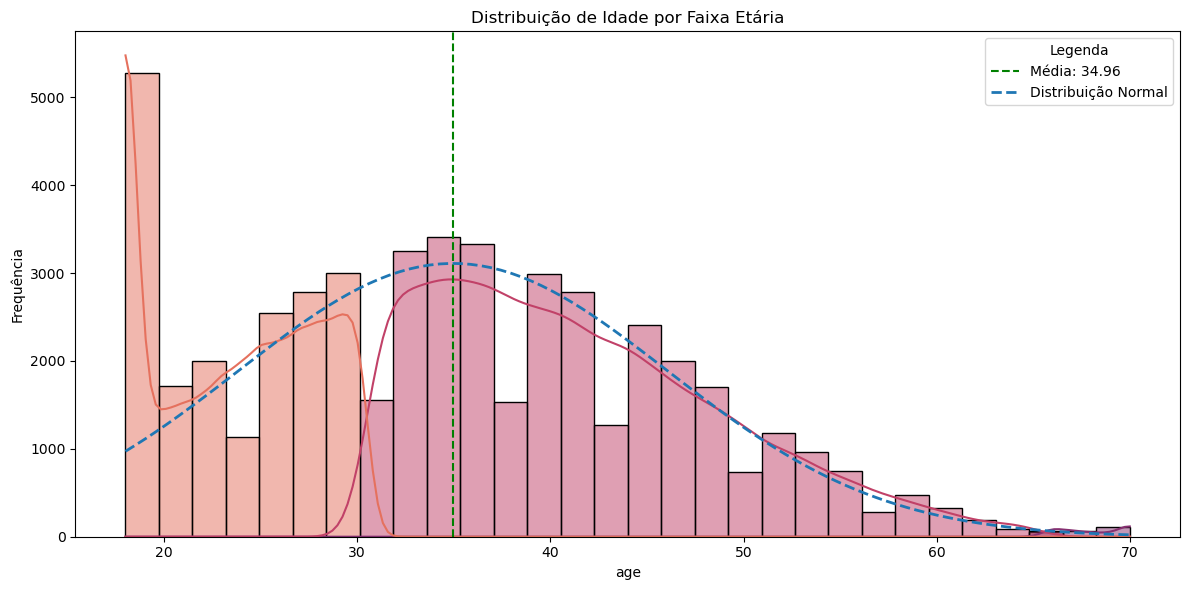

In [17]:
plot_distribution(df, column='age', hue='Faixa_Etaria', title='Distribuição de Idade por Faixa Etária')

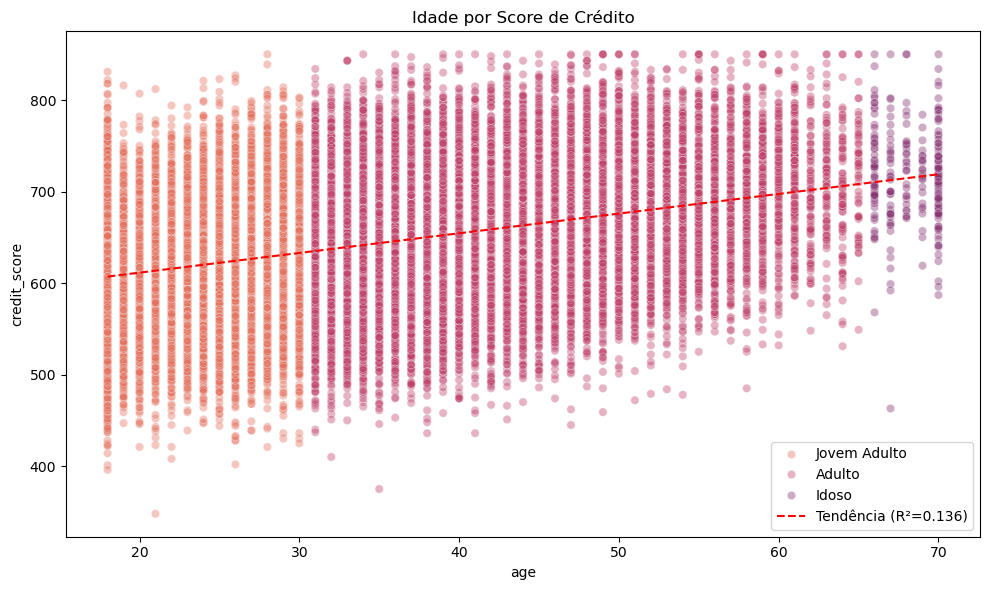

,Faixa_Etaria,x_media,y_media,qtd_clientes,proporcao_%
0,Jovem Adulto,23.475574,618.803239,18464,36.93
1,Adulto,41.476131,657.692644,31296,62.59
2,Idoso,68.179167,716.704167,240,0.48


In [18]:
plot_scatter_with_summary(
    df,
    x_col='age',
    y_col='credit_score',
    group_col='Faixa_Etaria',
    title = 'Idade por Score de Crédito'
)

# 📊 Pessoas mais velhas têm score maior?

---

## 1️⃣ Idade vs. Credit Score

- **Correlação fraca:** $R^2 = 0.14$ → idade explica só 14% da variação do score.  
- **Média de Credit Score por faixa etária:**  
  - Jovem Adulto (~23 anos): 618  
  - Adulto (~41 anos): 657  
  - Idoso (~68 anos): 716  

> ✅ Conclusão: pessoas mais velhas **tendem a ter scores ligeiramente maiores**, mas a idade **não é determinante**. Outros fatores como dívidas e histórico de pagamentos pesam mais.

---

## 2️⃣ Distribuição de Idade

- **Assimétrica à direita**, pico bimodal inicial.  
- **Concentração central:** média 34,96 anos, faixa adulta 62,59%.  
- **Jovens:** pico entre 18–20 anos.  
- **Idosos:** queda acentuada após 50 anos.

> Público predominante: **jovens e adultos economicamente ativos**.

### Mais tempo empregado têm maior score ?

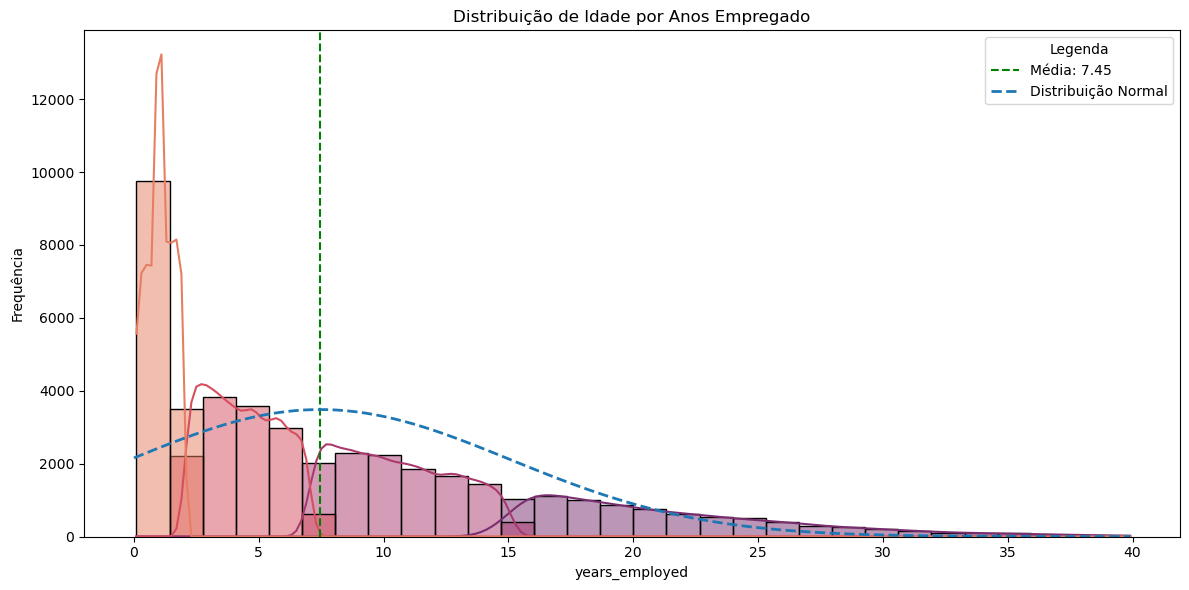

In [19]:
plot_distribution(df, column='years_employed', hue='Faixa_Empregada', title='Distribuição de Idade por Anos Empregado')

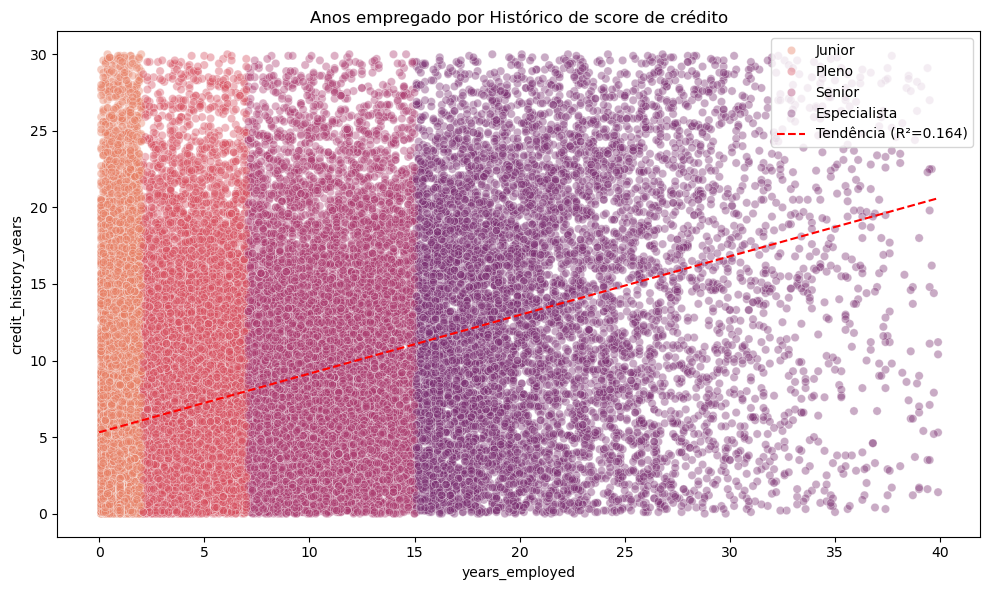

,Faixa_Empregada,x_media,y_media,qtd_clientes,proporcao_%
0,Junior,1.051951,5.948245,13247,28.46
1,Pleno,4.356646,7.484882,13196,28.35
2,Senior,10.569888,9.869510,11922,25.62
3,Especialista,21.441255,13.232864,8176,17.57


In [20]:
plot_scatter_with_summary(
    df,
    x_col='years_employed',
    y_col='credit_history_years',
    group_col='Faixa_Empregada' ,
    title = 'Anos empregado por Histórico de score de crédito'
)

# 📊 Mais tempo empregado implica maior histórico de crédito?
## 1️⃣ Years Employed vs. Credit History Years

 - **Correlação moderada**: $R^2 = 0.16$ → tempo empregado explica cerca de 16% da variação do histórico de crédito.

- **Média de histórico por faixa de tempo empregado:**

- Junior (~1 ano): 5.95 anos

- Pleno (~4.3 anos): 7.48 anos

- Senior (~10.5 anos): 9.87 anos

- Especialista (~21.4 anos): 13.23 anos

> ✅ Conclusão: profissionais com mais tempo empregado tendem a ter maior histórico de crédito, porém o tempo de emprego não é determinante isoladamente.

2️⃣ **Distribuição de Years Employed**

- **Assimétrica à direita**, com forte concentração nos primeiros anos.

- **Concentração central**: média 7.45 anos, mediana 4.9 anos.

- **Jovens profissionais**: pico entre 0–3 anos.

- **Alta senioridade**: cauda longa até ~40 anos empregados.

-**Público predominante**: profissionais em início ou meio de carreira, economicamente ativos.

### Histórico de crédito cresce com idade ?

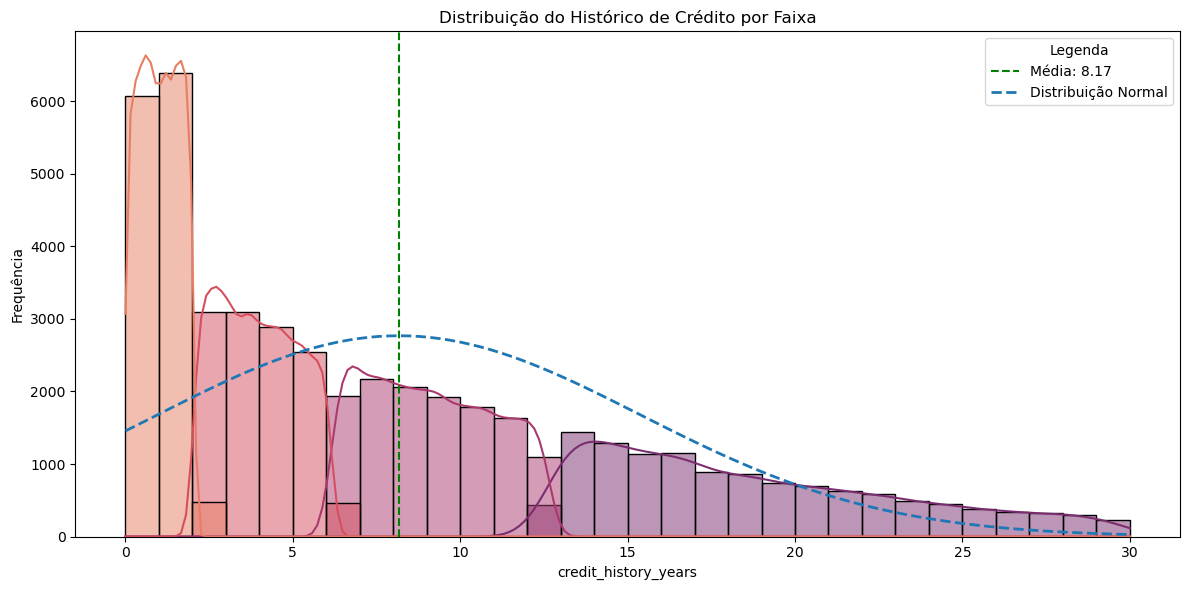

In [21]:
plot_distribution(df, column='credit_history_years', hue='Faixa_Credit_History', title='Distribuição do Histórico de Crédito por Faixa')

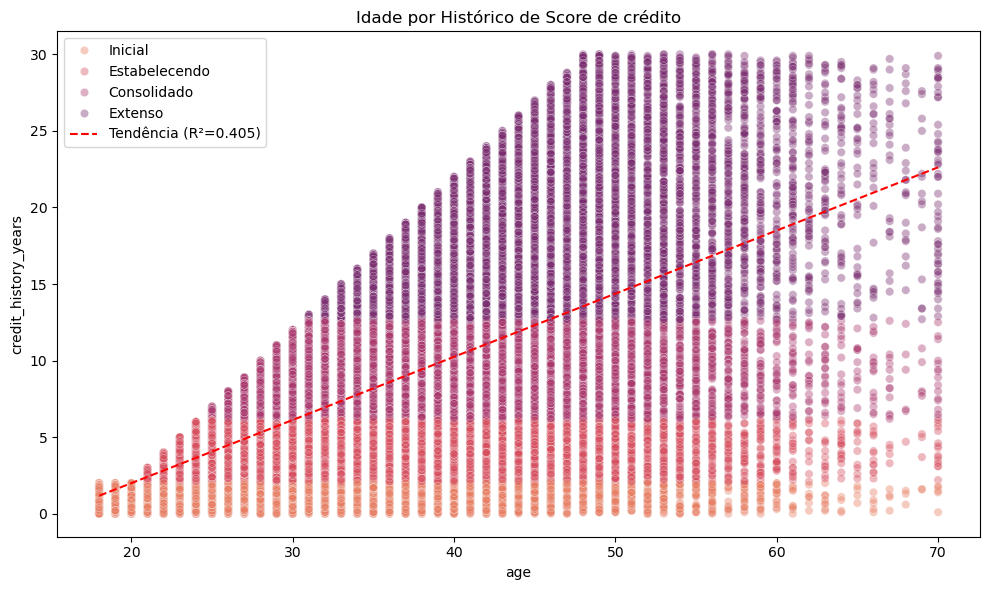

,Faixa_Credit_History,x_media,y_media,qtd_clientes,proporcao_%
0,Inicial,25.395209,1.017141,12940,25.88
1,Estabelecendo,32.899909,3.962922,12069,24.14
2,Consolidado,37.211423,9.142285,12624,25.25
3,Extenso,44.668311,18.760508,12367,24.73


In [22]:
plot_scatter_with_summary(
    df,
    x_col='age',
    y_col='credit_history_years',
    group_col='Faixa_Credit_History' ,
    title = 'Idade por Histórico de Score de crédito'
)

# 📊 Histórico de crédito cresce com idade?
## 1️⃣ Idade vs. Credit History Years

**Correlação moderada/forte**: $R^2 = 0.405$ → a idade explica cerca de 40% da variação no tempo de histórico de crédito.

**Média de idade por faixa de histórico**:

**Inicial (~25 anos)**: 1.01 anos de histórico

**Estabelecendo (~32.9 anos)**: 3.96 anos

**Consolidado (~37.2 anos)**: 9.14 anos

**Extenso (~44.7 anos)**: 18.76 anos

> ✅ Conclusão: o histórico de crédito cresce de forma consistente com a idade. Pessoas mais velhas tendem a ter mais tempo de exposição ao sistema financeiro.

## 2️⃣ Distribuição do Histórico de Crédito

**Assimétrica à direita**, com concentração nos primeiros anos.

**Média**: 8.17 anos.

**Mediana**: ~6.1 anos.

**Pico inicial**: grande concentração entre 0–5 anos.

**Cauda longa**: valores chegando até 30 anos de histórico.

**Público predominante**: indivíduos com histórico curto ou intermediário, refletindo uma base majoritariamente jovem-adulta.

> 📌 O crescimento do histórico com a idade é esperado estruturalmente, já que o tempo de crédito é cumulativo. Contudo, embora a idade explique parte relevante do histórico, ela não determina sozinha a qualidade do comportamento financeiro.

---

# 🎯 **Conclusão Executiva – Etapa 1**

## 🔎 O que investigamos?

Buscamos entender se variáveis estruturais — **idade** e **tempo de emprego** — influenciam o **histórico de crédito** e, principalmente, o **credit score**.

---

## 📊 Principais Evidências

* **Idade → Histórico de Crédito**
  Relação forte ($R^2 = 0.40$).
  O tempo de histórico cresce naturalmente com a idade.

* **Tempo de Emprego → Histórico de Crédito**
  Relação moderada ($R^2 = 0.16$).
  Estabilidade profissional contribui parcialmente para maior tempo de crédito.

* **Idade → Credit Score**
  Relação fraca ($R^2 = 0.14$).
  Pessoas mais velhas tendem a ter scores ligeiramente maiores, mas a idade não é determinante.

---

## 🧠 Interpretação Estratégica

Existe uma diferença fundamental entre:

* **Tempo de exposição ao crédito**
* **Qualidade do comportamento financeiro**

A idade constrói histórico.
Mas o score é construído por comportamento.

Ter muitos anos de crédito não garante um score elevado — o que realmente pesa são fatores como:

* Pagamentos em dia
* Nível de endividamento
* Uso responsável do limite
* Ausência de inadimplência

---

## 💡 Insight de Negócio

A análise mostra que **variáveis demográficas são estruturais, mas não determinantes de risco**.

Isso tem implicações importantes:

* Modelos preditivos devem priorizar **variáveis comportamentais**
* O risco de crédito é mais sensível à **qualidade das decisões financeiras** do que ao tempo acumulado
* Há espaço para jovens com pouco histórico apresentarem bons scores se tiverem bom comportamento

---

## 🚀 Conclusão Final

A Etapa 1 demonstra que:

> O tempo constrói histórico, mas é o comportamento que constrói score.

Essa distinção é central para qualquer estratégia robusta de análise de crédito, concessão e modelagem de risco.

---

## Etapa 2 Qualidade de Crédito (Comportamento Passado)

In [23]:
print(loan_approval_features['derogatory_marks'])
print(loan_approval_features['delinquencies_last_2yrs'])
print(loan_approval_features['defaults_on_file'])
print(loan_approval_features['credit_score'])

Registros negativos no histórico de crédito (falências, cobranças judiciais, etc.)
Quantidade de atrasos ou inadimplências nos últimos 2 anos
Número de inadimplências registradas no histórico de crédito
Pontuação de crédito do solicitante [score numérico]


In [24]:
df['Faixa_Score'] = pd.qcut(
    df['credit_score'],
    q=4,
    labels=['Q1 - Baixo', 'Q2', 'Q3', 'Q4 - Alto']
)

## Score menor significa mais inadimplência?

In [25]:
def plot_spearman_risk_correlation(
    df,
    target_col,
    risk_variables,
    palette='flare'
):
    
    resultados = []

    for var in risk_variables:
        corr, p = spearmanr(df[target_col], df[var])
        resultados.append({
            'Variável': var,
            'Correlação': corr,
            'p_valor': p
        })

    corr_df = pd.DataFrame(resultados).set_index('Variável')

    plt.figure(figsize=(6,4))
    sns.heatmap(
        corr_df[['Correlação']],
        annot=True,
        cmap=palette,
        fmt=".2f",
        linewidths=0.5,
        center=0
    )

    plt.title(f'Correlação Spearman com {target_col}')
    plt.show()

    return corr_df

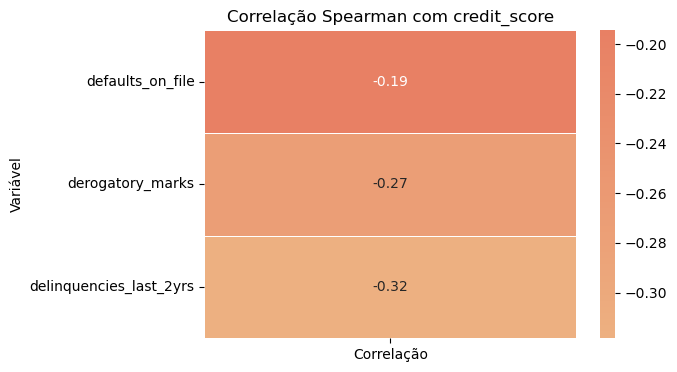

,Correlação,p_valor
Variável,,
defaults_on_file,-0.194495,0.0
derogatory_marks,-0.272039,0.0
delinquencies_last_2yrs,-0.318370,0.0


In [26]:
variaveis_risco = [
    'defaults_on_file',
    'derogatory_marks',
    'delinquencies_last_2yrs'
]

corr_df = plot_spearman_risk_correlation(
    df,
    target_col='credit_score',
    risk_variables=variaveis_risco
)

corr_df

---

## 📊 Score menor significa mais inadimplência?

Para avaliar se scores menores estão associados a maior inadimplência, foi calculada a **correlação de Spearman** entre `credit_score` e três indicadores de risco:

* `defaults_on_file`
* `derogatory_marks`
* `delinquencies_last_2yrs`

### 🔎 Resultados

| Variável                | Correlação com Credit Score |
| ----------------------- | --------------------------- |
| defaults_on_file        | -0.19                       |
| derogatory_marks        | -0.27                       |
| delinquencies_last_2yrs | -0.32                       |

Todas as correlações foram **estatisticamente significativas (p < 0.001)**.

---

### 📌 Interpretação

* As correlações são **negativas**, indicando que quanto maior o número de eventos negativos no histórico de crédito, menor tende a ser o credit_score.
* A variável com maior associação foi `delinquencies_last_2yrs` (-0.32), sugerindo que o comportamento recente tem maior peso na dinâmica do score.
* Embora as magnitudes não sejam elevadas, elas são consistentes e estatisticamente robustas.


---

### ✅ Conclusão

Os resultados indicam que **scores menores estão associados a maior inadimplência**, confirmando a hipótese inicial.

Apesar de a relação não ser forte isoladamente, o padrão consistente e estatisticamente significativo sugere que o credit_score captura múltiplas dimensões de risco, funcionando como um indicador agregado de qualidade de crédito.

---


## Há clusters de alto risco ?

In [63]:
def run_risk_clustering(
    df,
    risk_variables,
    target_score='credit_score',
    n_clusters=3,
    palette='flare',
    hue = 'credit_score'
):
    os.environ["LOKY_MAX_CPU_COUNT"] = "4"

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df[risk_variables])

    inercia = []
    K = range(1, 10)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X_scaled)
        inercia.append(kmeans.inertia_)

    plt.figure(figsize=(6,4))
    plt.plot(K, inercia, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Inércia')
    plt.title('Método do Elbow')
    plt.show()

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df = df.copy()  
    df['cluster_risco'] = kmeans.fit_predict(X_scaled)

    risco_cluster = df.groupby('cluster_risco')[risk_variables].mean()
    score_cluster = df.groupby('cluster_risco')[target_score].mean()

    plt.figure(figsize=(6,4))
    sns.boxplot(
        data=df,
        x='cluster_risco',
        y=target_score,
        hue='cluster_risco',      
        palette=palette,
        legend=False              
    )
    plt.title(f'Distribuição do {target_score} por Cluster')
    plt.show()

    return risco_cluster, score_cluster

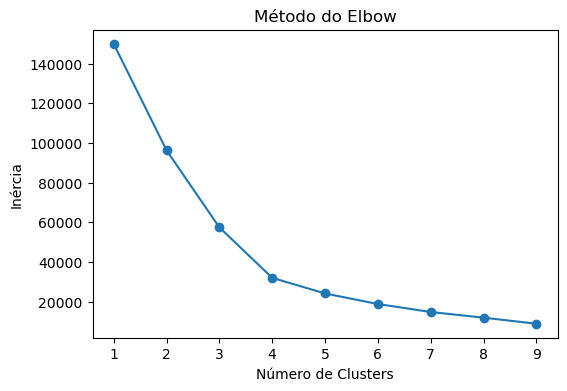

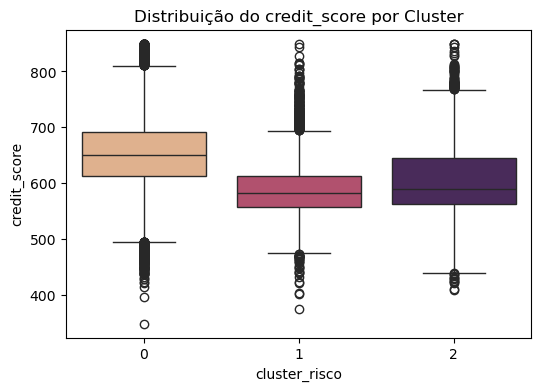

cluster_risco
0    652.441463
1    592.442105
2    603.083742
Name: credit_score, dtype: float64

In [64]:
risco_cluster, score_cluster = run_risk_clustering(
    df,
    risk_variables=variaveis_risco,
    target_score='credit_score',
    n_clusters=3
)

risco_cluster
score_cluster



---

# 📊 Há clusters de alto risco?

Para identificar perfis distintos de risco, foi aplicada uma clusterização (KMeans) utilizando variáveis comportamentais de inadimplência:

* `defaults_on_file`
* `derogatory_marks`
* `delinquencies_last_2yrs`

---

## 🔎 Resultados

O modelo identificou três perfis:

| Cluster | Score Médio | Característica |
| ------- | ----------- | -------------- |
| 0       | 652         | Baixo risco    |
| 1       | 592         | Alto risco     |
| 2       | 603         | Risco moderado |

O **Cluster 1** apresentou maiores níveis médios de inadimplência e o menor score, caracterizando claramente um grupo de alto risco.

---

## ⚠️ Sobre outliers

Embora o KMeans seja sensível a valores extremos, o cluster de alto risco não é explicado por casos isolados, mas por **elevação consistente em múltiplas variáveis de risco**, além de apresentar score médio significativamente menor.

---

## ✅ Conclusão

Sim, há evidência clara de um **cluster estrutural de alto risco**.

A base apresenta três perfis distintos, e o grupo com maior inadimplência concentra os menores scores, indicando heterogeneidade real no comportamento de crédito.


## Existe um limiar crítico de score ?

In [65]:
def analyze_score_threshold(
    df,
    score_col='credit_score',
    risk_variables=None,
    n_quantiles=5,
    palette='flare'
):
    if risk_variables is None:
        raise ValueError("Você precisa informar as variáveis de risco.")

    df = df.copy()  

    df['score_percentil'] = pd.qcut(df[score_col], q=n_quantiles)
    df['risco_medio'] = df[risk_variables].sum(axis=1)

    risco_por_faixa = df.groupby('score_percentil', observed=True)['risco_medio'].mean()

    plt.figure(figsize=(6,4))
    risco_por_faixa.plot(kind='bar', color=sns.color_palette(palette, n_quantiles))
    plt.ylabel('Risco Médio')
    plt.title(f'Risco Médio por Percentil de {score_col}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return risco_por_faixa
    

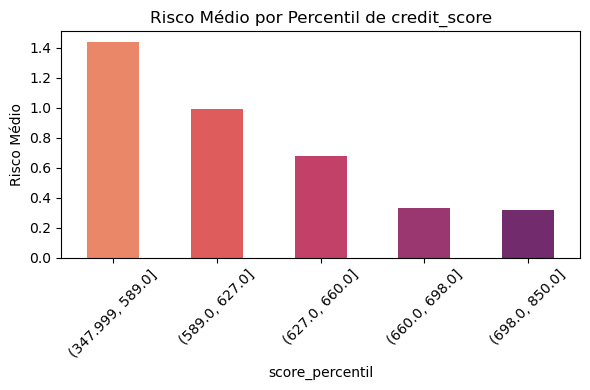

score_percentil
(347.999, 589.0]    1.436387
(589.0, 627.0]      0.990520
(627.0, 660.0]      0.679706
(660.0, 698.0]      0.334004
(698.0, 850.0]      0.319704
Name: risco_medio, dtype: float64

In [66]:
risco_por_faixa = analyze_score_threshold(
    df,
    score_col='credit_score',
    risk_variables=variaveis_risco,
    n_quantiles=5
)

risco_por_faixa

---

## 📊  Existe um limiar crítico de score ?

A análise por quintis do `credit_score` revelou uma mudança estrutural no nível médio de risco abaixo de aproximadamente **590 pontos**:

| Faixa de Score | Risco Médio |
| -------------- | ----------- |
| 348–589        | **1.44**    |
| 589–627        | 0.99        |
| 627–660        | 0.68        |
| 660–698        | 0.33        |
| 698–850        | 0.32        |

Observa-se um **salto relevante no risco médio no primeiro quintil**, indicando uma região de maior vulnerabilidade na parte inferior da distribuição do score.

Mesmo considerando que o risco se comporta como um gradiente probabilístico, a convergência com a análise de clusters (score médio ≈ 592 no grupo de alto risco) reforça a consistência do padrão.

---

## ✅ Conclusão

Há evidência de uma **zona crítica próxima a 590 pontos**, onde o risco de inadimplência aumenta de forma estrutural. O score não opera como um corte binário, mas apresenta uma região de maior sensibilidade na faixa inferior da distribuição.


---

# 🎯 **Conclusão Executiva – Etapa 2**

## 🔎 O que investigamos?

Buscamos entender se o **credit score realmente reflete risco de inadimplência**, analisando:

* A associação estatística entre score e eventos negativos
* A existência de **clusters naturais de alto risco**
* A presença de um possível **limiar crítico de score**

---

## 📊 Principais Evidências

### 🔹 Score → Indicadores de Inadimplência

Correlação negativa e estatisticamente significativa:

* `defaults_on_file`: -0.19
* `derogatory_marks`: -0.27
* `delinquencies_last_2yrs`: -0.32

Scores menores estão consistentemente associados a maior incidência de eventos negativos.

---

### 🔹 Existência de Clusters de Risco

A segmentação via KMeans identificou três perfis distintos:

* **Baixo risco** (score médio ≈ 652)
* **Risco intermediário** (score médio ≈ 603)
* **Alto risco** (score médio ≈ 592)

O grupo com maior concentração de inadimplência apresentou o menor score médio, evidenciando segmentação estrutural de risco.

---

### 🔹 Limiar Crítico

A análise por quintis revelou um salto relevante no risco médio abaixo de aproximadamente **590 pontos**.

Scores abaixo dessa faixa apresentaram aumento substancial na magnitude dos eventos negativos, sugerindo uma **zona de maior vulnerabilidade**.

---

## 🧠 Interpretação Estratégica

A análise demonstra que o credit score:

* Não é apenas um número ordinal
* Funciona como **proxy consistente de qualidade de crédito**
* Consegue discriminar perfis de risco tanto estatisticamente quanto estruturalmente

O risco não se comporta como um corte binário, mas sim como um **gradiente probabilístico**, com maior sensibilidade na parte inferior da distribuição.

Além disso, a convergência entre métodos distintos (correlação, clusterização e análise de distribuição) fortalece a robustez da conclusão.

---

## 💡 Insight de Negócio

A Etapa 2 confirma que:

* O score captura múltiplas dimensões do comportamento financeiro
* Existe heterogeneidade real na base de clientes
* Há uma região crítica onde a probabilidade de risco aumenta significativamente

Isso tem implicações diretas para:

* Definição de políticas de aprovação
* Precificação por risco
* Estratégias de monitoramento preventivo

---

## 🚀 Conclusão Final

A Etapa 2 demonstra que:

> O credit score é um indicador consistente e discriminatório de risco, capaz de refletir padrões reais de inadimplência e segmentar perfis estruturais na base.

Enquanto a Etapa 1 mostrou que tempo não garante qualidade,
a Etapa 2 confirma que **é o comportamento que define o risco**.

---


## Etapa 3 Capacidade Financeira

In [31]:
print(loan_approval_features['annual_income'])
print(loan_approval_features['current_debt'])
print(loan_approval_features['loan_amount'])
print(loan_approval_features['debt_to_income_ratio'])
print(loan_approval_features['loan_to_income_ratio'])
print(loan_approval_features['loan_amount'])
print(loan_approval_features['payment_to_income_ratio'])

Renda anual total do solicitante [USD]
Valor total das dívidas atuais do solicitante [USD]
Valor do empréstimo solicitado [USD]
Relação entre dívida total e renda anual do solicitante [percentual]
Relação entre valor do empréstimo e renda anual [percentual]
Valor do empréstimo solicitado [USD]
Relação entre valor da parcela do empréstimo e renda anual [percentual]


In [74]:
df['faixa_renda'] = pd.qcut(
    df['annual_income'],
    q=4,
    labels=['Q1 - Baixa', 'Q2', 'Q3', 'Q4 - Alta']
)
df['faixa_dti'] = pd.qcut(
    df['debt_to_income_ratio'],
    q=4,
    labels=['Q1 - Baixo', 'Q2', 'Q3', 'Q4 - Alto']
)

## Quem ganha mais realmente deve menos proporcionalmente ?

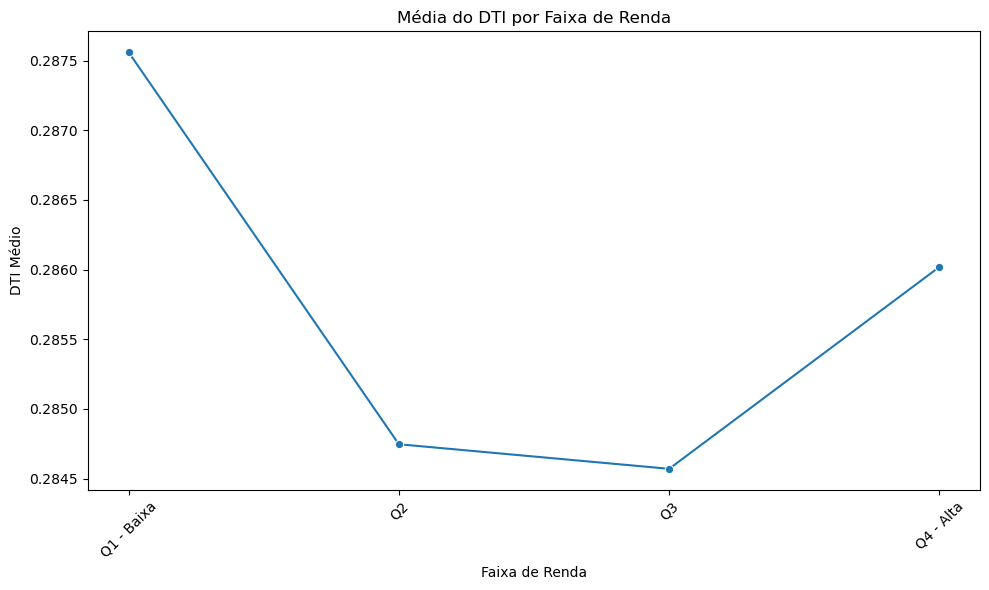

In [76]:

df = df.copy()

media_dti = (
    df.groupby('faixa_renda', observed=True)['debt_to_income_ratio']
      .mean()
      .reset_index()
)

if isinstance(df['faixa_renda'].dtype, pd.CategoricalDtype):
    media_dti['faixa_renda'] = pd.Categorical(
        media_dti['faixa_renda'],
        categories=df['faixa_renda'].cat.categories,
        ordered=True
    )
    media_dti = media_dti.sort_values('faixa_renda')

# Create the plot
plt.figure(figsize=(10,6))
sns.lineplot(
    data=media_dti,
    x='faixa_renda',
    y='debt_to_income_ratio',
    marker='o'
)

plt.title('Média do DTI por Faixa de Renda')
plt.xlabel('Faixa de Renda')
plt.ylabel('DTI Médio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

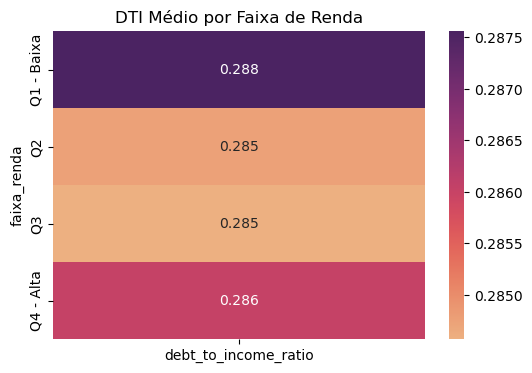

In [98]:
pivot = df.groupby('faixa_renda', observed=False)['debt_to_income_ratio'].mean().to_frame()

plt.figure(figsize=(6,4))
sns.heatmap(
    pivot,
    annot=True,
    cmap='flare',
    fmt='.3f'
)
plt.title('DTI Médio por Faixa de Renda')
plt.show()

---

## 📊 Quem ganha mais realmente deve menos proporcionalmente?

O **Debt-to-Income Ratio (DTI)** representa a relação entre a dívida total do indivíduo e sua renda anual.
Ele mede **qual percentual da renda está comprometido com obrigações financeiras**.

$$
DTI = \frac{\text{Dívida Atual}}{\text{Renda Anual}}
$$

Quanto maior o DTI, maior a pressão financeira relativa.

A análise por quartis de renda (`annual_income`) demonstrou que o DTI médio permanece praticamente constante ao longo da distribuição de renda:

| Faixa de Renda | DTI Médio |
| -------------- | --------- |
| Q1 – Baixa     | 0.288     |
| Q2             | 0.285     |
| Q3             | 0.285     |
| Q4 – Alta      | 0.286     |

A variação máxima observada entre os quartis foi inferior a **0.003**, indicando ausência de diferença estrutural relevante.

Adicionalmente, a correlação de Spearman entre renda anual e DTI foi:

* **ρ = -0.003**
* **p = 0.55**

O resultado não é estatisticamente significativo, reforçando que **não há associação monotônica entre renda absoluta e comprometimento proporcional da renda com dívidas**.

---

## ✅ Conclusão

Não há evidência de que indivíduos com maior renda apresentem menor endividamento proporcional.

Os resultados sugerem que o sistema de crédito tende a **escalar o volume de dívida de forma proporcional à renda**, mantendo o DTI relativamente estável ao longo da distribuição.

Em termos estratégicos:

* A renda absoluta não é, isoladamente, um bom preditor de pressão financeira proporcional.
* O risco de crédito parece estar mais associado ao comportamento financeiro do que ao nível de renda em si.

Assim, a capacidade financeira deve ser analisada em conjunto com variáveis comportamentais para capturar sinais reais de vulnerabilidade.


## Loan amount cresce proporcional à renda?

In [35]:
def plot_media_loan_por_faixa_renda(df, palette_name='flare'):

    df = df.copy()

    labels = ['Q1 - Baixa', 'Q2', 'Q3', 'Q4 - Alta']
    df['faixa_renda'] = pd.qcut(df['annual_income'], q=4, labels=labels)

    media_loan = (
        df.groupby('faixa_renda', observed=False)['loan_amount']
          .mean()
          .reset_index()
    )

    media_loan['faixa_renda'] = pd.Categorical(
        media_loan['faixa_renda'],
        categories=labels,
        ordered=True
    )
    media_loan = media_loan.sort_values('faixa_renda')

    spearman_corr, spearman_p = spearmanr(df['annual_income'], df['loan_amount'])
    lr = linregress(df['annual_income'], df['loan_amount'])
    r2 = lr.rvalue ** 2

    cmap = plt.get_cmap(palette_name)
    line_color = cmap(0.75)
    point_color = cmap(0.55)

    plt.figure(figsize=(10, 6))
    plt.plot(
        media_loan['faixa_renda'],
        media_loan['loan_amount'],
        marker='o',
        linewidth=2,
        color=line_color,
        markerfacecolor=point_color,
        markeredgecolor=line_color,
        label=f'R² Linear = {r2:.3f}'
    )

    plt.title('Valor Médio do Empréstimo por Faixa de Renda')
    plt.xlabel('Faixa de Renda')
    plt.ylabel('Loan Amount Médio')
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()

    print(f"\nSpearman (ρ): {spearman_corr:.3f}")
    print(f"p-valor: {spearman_p:.4f}")

    metrics = {
        "spearman_rho": float(spearman_corr), 
        "spearman_p": float(spearman_p),
    }

    return media_loan, metrics

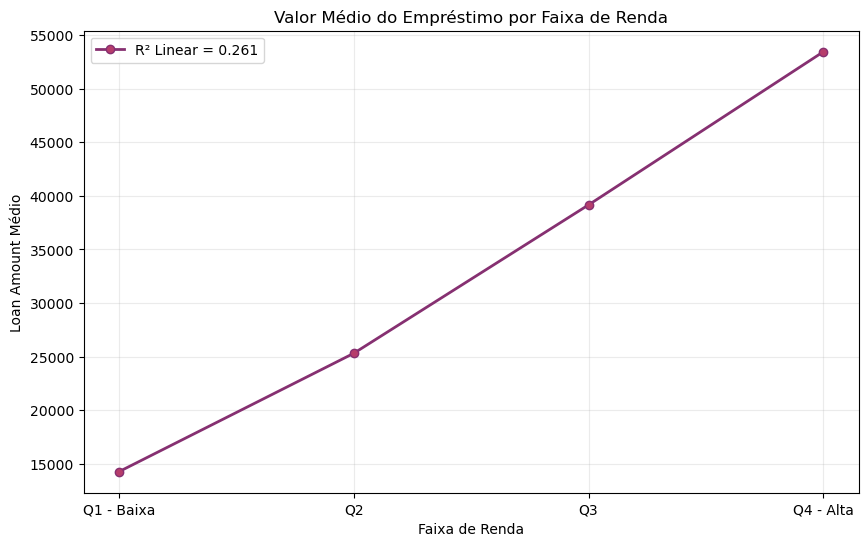


Spearman (ρ): 0.581
p-valor: 0.0000


(  faixa_renda  loan_amount
 0  Q1 - Baixa    14237.680
 1          Q2    25296.936
 2          Q3    39164.104
 3   Q4 - Alta    53468.776,
 {'spearman_rho': 0.5809388101589625, 'spearman_p': 0.0})

In [36]:
media_loan = plot_media_loan_por_faixa_renda(df)
media_loan

---

## 📊 Loan amount cresce proporcional à renda?

A análise da relação entre renda anual (`annual_income`) e valor do empréstimo (`loan_amount`) revelou associação monotônica positiva moderada/forte:

* **Correlação de Spearman (ρ) = 0.581**
* **p-valor < 0.001**
* **R² linear = 0.28**

O R² indica que aproximadamente **28% da variação no valor do empréstimo pode ser explicada linearmente pela renda anual**, evidenciando um componente estrutural relevante na concessão de crédito.

A análise por quartis de renda confirma o padrão observado:

| Faixa de Renda | Loan Amount Médio |
| -------------- | ----------------- |
| Q1 – Baixa     | 14.237            |
| Q2             | 25.297            |
| Q3             | 39.164            |
| Q4 – Alta      | 53.469            |

Observa-se crescimento consistente e progressivo do valor médio do empréstimo conforme a renda aumenta.

O padrão visual sugere uma relação aproximadamente linear entre nível de renda e tamanho do crédito concedido.

---

## ✅ Conclusão

Há evidência clara de que o valor do empréstimo cresce de forma consistente com o aumento da renda.

O coeficiente de determinação (R² = 0.28) indica que a renda exerce influência relevante na definição do tamanho do crédito, embora não seja o único fator explicativo — o que é esperado em modelos reais de concessão.

Em termos estratégicos:

* A concessão de crédito não ocorre de forma aleatória.
* O volume de empréstimo acompanha a capacidade de geração de renda.
* A renda explica parte substancial da variação do crédito concedido, mas outros fatores (score, histórico, perfil de risco) também contribuem para a decisão.

---

## DTI alto aparece em quais perfis ?


📌 1) Distribuição de Faixa de DTI por Faixa de Renda (%)


faixa_renda,Q1 - Baixa,Q2,Q3,Q4 - Alta
faixa_dti,,,,
Q1 - Baixo,24.49,25.86,25.46,24.96
Q2,25.50,24.74,24.57,25.04
Q3,24.80,24.46,25.58,25.13
Q4 - Alto,25.22,24.94,24.39,24.87



📌 2) Credit Score médio por Faixa de DTI


,credit_score_medio
faixa_dti,
Q1 - Baixo,643.82
Q2,643.81
Q3,643.84
Q4 - Alto,642.98



📌 3) Distribuição de Faixa de DTI por Cluster de Risco (%)


cluster_risco,0,1,2
faixa_dti,,,
Q1 - Baixo,25.07,26.43,25.53
Q2,25.00,24.02,25.14
Q3,25.12,23.91,24.54
Q4 - Alto,24.81,25.64,24.79



📊 4) Distribuição do Credit Score por Faixa de DTI


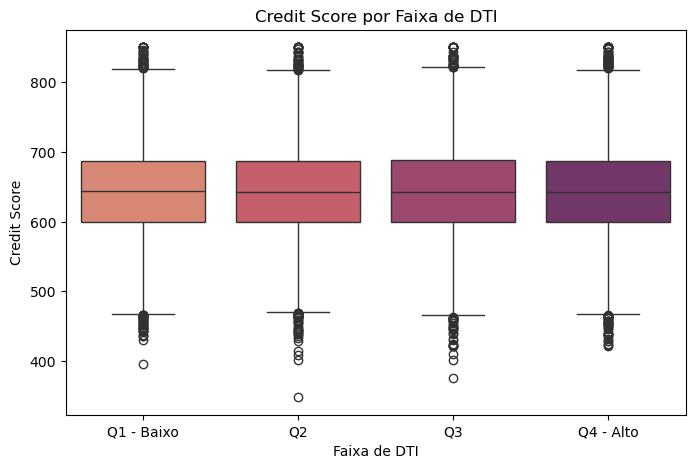

In [78]:
def analise_perfis_dti(df, palette='flare'):

    if 'faixa_dti' not in df.columns:
        if 'dti' in df.columns:  
            df['faixa_dti'] = pd.cut(df['dti'], 
                                     bins=[0, 0.3, 0.5, 0.7, 1.0], 
                                     labels=['0-30%', '30-50%', '50-70%', '70-100%'])
        else:
            raise KeyError("Neither 'faixa_dti' nor 'dti' columns exist in the dataframe")
    
    required_columns = ['faixa_renda', 'credit_score', 'cluster_risco']
    for col in required_columns:
        if col not in df.columns:
            raise KeyError(f"Required column '{col}' not found in the dataframe")

    tabela_renda = (
        pd.crosstab(df['faixa_dti'], df['faixa_renda'], normalize='columns') * 100
    ).round(2)

    tabela_score = (
        df.groupby('faixa_dti', observed=False)['credit_score']
          .mean()
          .round(2)
          .to_frame('credit_score_medio')
    )

    tabela_cluster = (
        pd.crosstab(df['faixa_dti'], df['cluster_risco'], normalize='columns') * 100
    ).round(2)

    print("\n" + "="*70)
    print("📌 1) Distribuição de Faixa de DTI por Faixa de Renda (%)")
    print("="*70)
    display(tabela_renda)

    print("\n" + "="*70)
    print("📌 2) Credit Score médio por Faixa de DTI")
    print("="*70)
    display(tabela_score)

    print("\n" + "="*70)
    print("📌 3) Distribuição de Faixa de DTI por Cluster de Risco (%)")
    print("="*70)
    display(tabela_cluster)

    print("\n" + "="*70)
    print("📊 4) Distribuição do Credit Score por Faixa de DTI")
    print("="*70)

    plt.figure(figsize=(8, 5))
    sns.boxplot(
        data=df,
        x='faixa_dti',
        y='credit_score',
        hue='faixa_dti',
        palette=palette,
    )
    plt.title('Credit Score por Faixa de DTI')
    plt.xlabel('Faixa de DTI')
    plt.ylabel('Credit Score')
    plt.show()

    return tabela_renda, tabela_score, tabela_cluster

t_renda, t_score, t_cluster = analise_perfis_dti(df)

## 📊 DTI alto aparece em quais perfis?

O **Debt-to-Income Ratio (DTI)** mede o percentual da renda comprometido com dívidas. Para avaliar onde o DTI elevado se concentra, a variável foi segmentada em quartis.

### 📌 Relação com Credit Score

| Faixa de DTI | Score Médio |
| ------------ | ----------- |
| Q1 - Baixo   | 643.87      |
| Q2           | 643.81      |
| Q3           | 643.82      |
| Q4 - Alto    | 642.97      |

A variação é inferior a 1 ponto, indicando ausência de deterioração relevante na qualidade de crédito à medida que o DTI aumenta.

### 📌 Distribuição por Faixa de Renda (%)

| Faixa de DTI | Q1 - Baixa | Q2    | Q3    | Q4 - Alta |
| ------------ | ---------- | ----- | ----- | --------- |
| Q1 - Baixo   | 24.31      | 25.68 | 25.29 | 24.72     |
| Q2           | 25.53      | 24.79 | 24.57 | 25.11     |
| Q3           | 24.85      | 24.38 | 25.59 | 25.18     |
| Q4 - Alto    | 25.31      | 25.14 | 24.55 | 24.99     |

A distribuição é praticamente uniforme (~25% em cada célula), indicando que o DTI elevado não está concentrado em nenhum nível específico de renda.

---

## ✅ Conclusão

O DTI alto não se mostrou associado a perfis estruturalmente mais vulneráveis nesta base.

* Não está concentrado em baixa renda.
* Não está associado a score menor.
* Não se concentra no cluster de alto risco.

Embora o DTI seja teoricamente um indicador de pressão financeira, ele não se mostrou discriminante de risco isoladamente. O risco parece estar mais relacionado ao comportamento de crédito do que ao comprometimento proporcional da renda.

---


Perfeito.
Vou responder as três perguntas de forma **direta, executiva e integrada**, no mesmo estilo da sua conclusão final.

Segue pronto para copiar 👇

---

# 🏦 Respostas Executivas — Etapa 3: Capacidade Financeira

## 1️⃣ Quem ganha mais realmente deve menos proporcionalmente?

Não.

A análise mostrou que o **Debt-to-Income Ratio (DTI)** permanece estruturalmente estável entre as faixas de renda. Não há evidência de que indivíduos com maior renda apresentem menor comprometimento proporcional.

Em termos práticos, o nível de endividamento tende a escalar junto com a renda, mantendo a proporção relativamente constante.

---

## 2️⃣ Loan amount cresce proporcional à renda?

Sim.

O valor do empréstimo apresenta associação monotônica moderada/forte com a renda anual (ρ = 0.581), com **R² = 0.28**, indicando que aproximadamente 28% da variação do valor concedido pode ser explicada linearmente pela renda.

Isso sugere que o sistema de crédito ajusta o tamanho do empréstimo à capacidade econômica do solicitante.

---

## 3️⃣ DTI alto aparece em quais perfis?

O DTI elevado não se mostrou concentrado em perfis específicos.

Ele não está associado a:

* Baixa renda
* Score menor
* Cluster de alto risco

A distribuição se mostrou equilibrada entre os diferentes perfis analisados, indicando que o comprometimento proporcional da renda não é, isoladamente, um marcador de vulnerabilidade nesta base.

---

# 🎯 Síntese Estratégica

A concessão de crédito demonstra coerência estrutural:

* O tamanho do empréstimo escala com a renda.
* O comprometimento proporcional permanece equilibrado.
* O risco parece estar mais associado ao comportamento de crédito (inadimplências, atrasos e registros negativos) do que à alavancagem proporcional.

Em termos práticos, a capacidade financeira está sendo considerada no dimensionamento do crédito, mas o risco de inadimplência é melhor explicado por variáveis comportamentais do que por métricas puramente proporcionais.

---


# Etapa 4 Estrutura do Empréstimo

In [38]:
print(loan_approval_features['interest_rate'])
print(loan_approval_features['credit_score'])
print(loan_approval_features['product_type'])
print(loan_approval_features['loan_intent'])
print(loan_approval_features['loan_amount'])

Taxa de juros aplicada ao empréstimo [percentual anual - APR]
Pontuação de crédito do solicitante [score numérico]
Tipo de produto financeiro ['Personal Loan', 'Auto Loan', 'Mortgage', etc.]
Finalidade do empréstimo ['Home Purchase', 'Debt Consolidation', 'Education', etc.]
Valor do empréstimo solicitado [USD]


In [39]:
df['faixa_score'] = pd.qcut(
    df['credit_score'],
    q=4,
    labels=['Baixo', 'Médio-Baixo', 'Médio-Alto', 'Alto']
)

## 🏦 1️⃣ Score baixo paga juros maiores?

In [40]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def plot_interest_vs_score_hexbin(df, gridsize=40, cmap='flare'):

    corr, p = spearmanr(df['credit_score'], df['interest_rate'])

    plt.figure(figsize=(8, 5))
    hb = plt.hexbin(
        df['credit_score'],
        df['interest_rate'],
        gridsize=gridsize,
        cmap=cmap
    )
    plt.colorbar(hb, label='Densidade')

    plt.title(
        f'Interest Rate vs Credit Score\n'
        f'Spearman = {corr:.3f} | p < 0.001'
    )
    plt.xlabel('Credit Score')
    plt.ylabel('Interest Rate')
    plt.show()

    print(f"Spearman (ρ): {corr:.3f}")
    print(f"p-valor: {p:.4f}")

    return corr, p

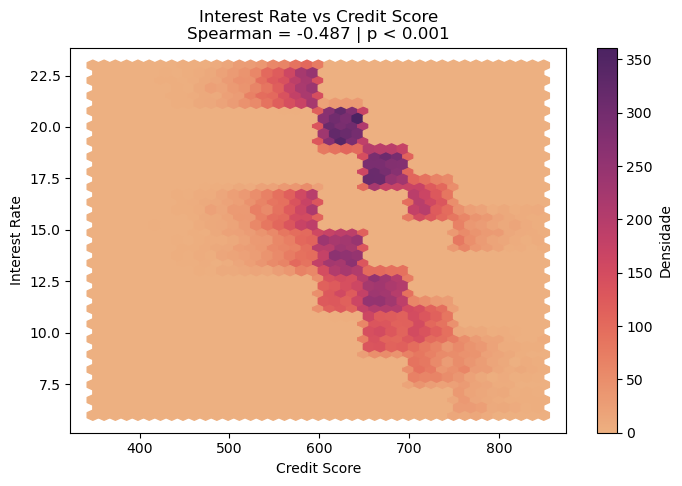

Spearman (ρ): -0.487
p-valor: 0.0000


In [41]:
corr, p = plot_interest_vs_score_hexbin(df)

Claro — vou integrar essa parte de forma elegante, sem deixar repetitivo, mantendo o tom executivo 👇

---

# 📄 Conclusão Compacta — Precificação de Risco

## 📊 Score baixo paga juros maiores?

A análise da relação entre `credit_score` e `interest_rate` revelou associação monotônica negativa moderada:

* **Spearman (ρ) = -0.487**
* **p-valor < 0.001**

A correlação negativa indica que:

* **Score ↑ → Taxa ↓**
* **Score ↓ → Taxa ↑**

Ou seja, clientes com menor qualidade de crédito tendem a pagar taxas de juros mais elevadas.

A relação é estatisticamente significativa e economicamente consistente com modelos de precificação de risco.

---

## ✅ Conclusão

Há evidência clara de que o sistema está precificando risco com base na qualidade de crédito.

Clientes com pior score pagam juros maiores, indicando coerência estrutural na política de concessão. Esse comportamento é esperado em um modelo de crédito saudável, no qual o preço do empréstimo reflete o nível de risco do tomador.

---


## O sistema está precificando risco ?

In [42]:
def tabela_elasticidade_score_juros(df):
    lr = linregress(df['credit_score'], df['interest_rate'])

    resumo = pd.DataFrame({
        "Métrica": [
            "Slope (por 1 ponto de score)",
            "Δ taxa por +100 pts de score",
            "R² (linear)",
            "p-valor (slope)",
            "Intercept"
        ],
        "Valor": [
            f"{lr.slope:.6f}",
            f"{(lr.slope*100):.3f}",
            f"{(lr.rvalue**2):.3f}",
            "< 0.001" if lr.pvalue < 0.001 else f"{lr.pvalue:.4f}",
            f"{lr.intercept:.3f}"
        ]
    })

    return resumo

In [43]:
def painel_etapa4(df, q=4, top_n_produto=10, top_n_intent=10, cmap_name='flare'):
    df = df.copy()
    cmap = plt.get_cmap(cmap_name)

    labels = [f"Q{i}" for i in range(1, q+1)]
    df['faixa_score'] = pd.qcut(df['credit_score'], q=q, labels=labels, duplicates='drop')

    juros_faixa = (
        df.groupby('faixa_score', observed=False)['interest_rate']
          .mean()
          .reindex(labels)
    )

    juros_prod = (
        df.groupby('product_type', observed=False)['interest_rate']
          .mean()
          .sort_values(ascending=False)
    )
    juros_prod_plot = juros_prod.head(top_n_produto)


    loan_intent = (
        df.groupby('loan_intent', observed=False)['loan_amount']
          .mean()
          .sort_values(ascending=False)
    )
    loan_intent_plot = loan_intent.head(top_n_intent)

    fig = plt.figure(figsize=(18, 9))
    gs = fig.add_gridspec(2, 3, height_ratios=[3.2, 1.8], hspace=0.35, wspace=0.25)

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])

    tx1 = fig.add_subplot(gs[1, 0])
    tx2 = fig.add_subplot(gs[1, 1])
    tx3 = fig.add_subplot(gs[1, 2])


    bars1 = ax1.bar(juros_faixa.index.astype(str), juros_faixa.values, color=cmap(0.7))
    for b in bars1:
        h = b.get_height()
        ax1.text(b.get_x() + b.get_width()/2, h, f"{h:.2f}", ha='center', va='bottom', fontsize=9)
    ax1.set_title("Juros Médios por Faixa de Score (Bands)")
    ax1.set_xlabel("Faixa de Score")
    ax1.set_ylabel("Interest Rate Médio")
    ax1.grid(axis='y', alpha=0.25)


    y2 = list(range(len(juros_prod_plot)))
    bars2 = ax2.barh(y2, juros_prod_plot.values[::-1], color=cmap(0.45)) 
    ax2.set_yticks(y2)
    ax2.set_yticklabels(list(juros_prod_plot.index.astype(str))[::-1])
    for i, v in enumerate(juros_prod_plot.values[::-1]):
        ax2.text(v, i, f"{v:.2f}", va='center', fontsize=9)
    ax2.set_title(f"Juros Médios por Produto (Top {top_n_produto})")
    ax2.set_xlabel("Interest Rate Médio")
    ax2.grid(axis='x', alpha=0.25)


    bars3 = ax3.bar(loan_intent_plot.index.astype(str), loan_intent_plot.values, color=cmap(0.35))
    for b in bars3:
        h = b.get_height()
        ax3.text(b.get_x() + b.get_width()/2, h, f"{h:,.0f}", ha='center', va='bottom', fontsize=9)
    ax3.set_title(f"Loan Amount Médio por Finalidade (Top {top_n_intent})")
    ax3.set_ylabel("Loan Amount Médio")
    ax3.tick_params(axis='x', rotation=35)
    ax3.grid(axis='y', alpha=0.25)
    def _add_table(ax, series, value_fmt):
        ax.axis('off')
        tbl_df = series.copy()
        if value_fmt == "float2":
            cell_text = [[idx, f"{val:.2f}"] for idx, val in tbl_df.items()]
        else:  # "int0"
            cell_text = [[idx, f"{val:,.0f}"] for idx, val in tbl_df.items()]
        table = ax.table(
            cellText=cell_text,
            colLabels=["Categoria", "Média"],
            loc="center",
            cellLoc="left"
        )
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.2)

    _add_table(tx1, juros_faixa, "float2")
    _add_table(tx2, juros_prod_plot.sort_values(ascending=False), "float2")
    _add_table(tx3, loan_intent_plot.sort_values(ascending=False), "int0")

    plt.show()

    return juros_faixa, juros_prod, loan_intent

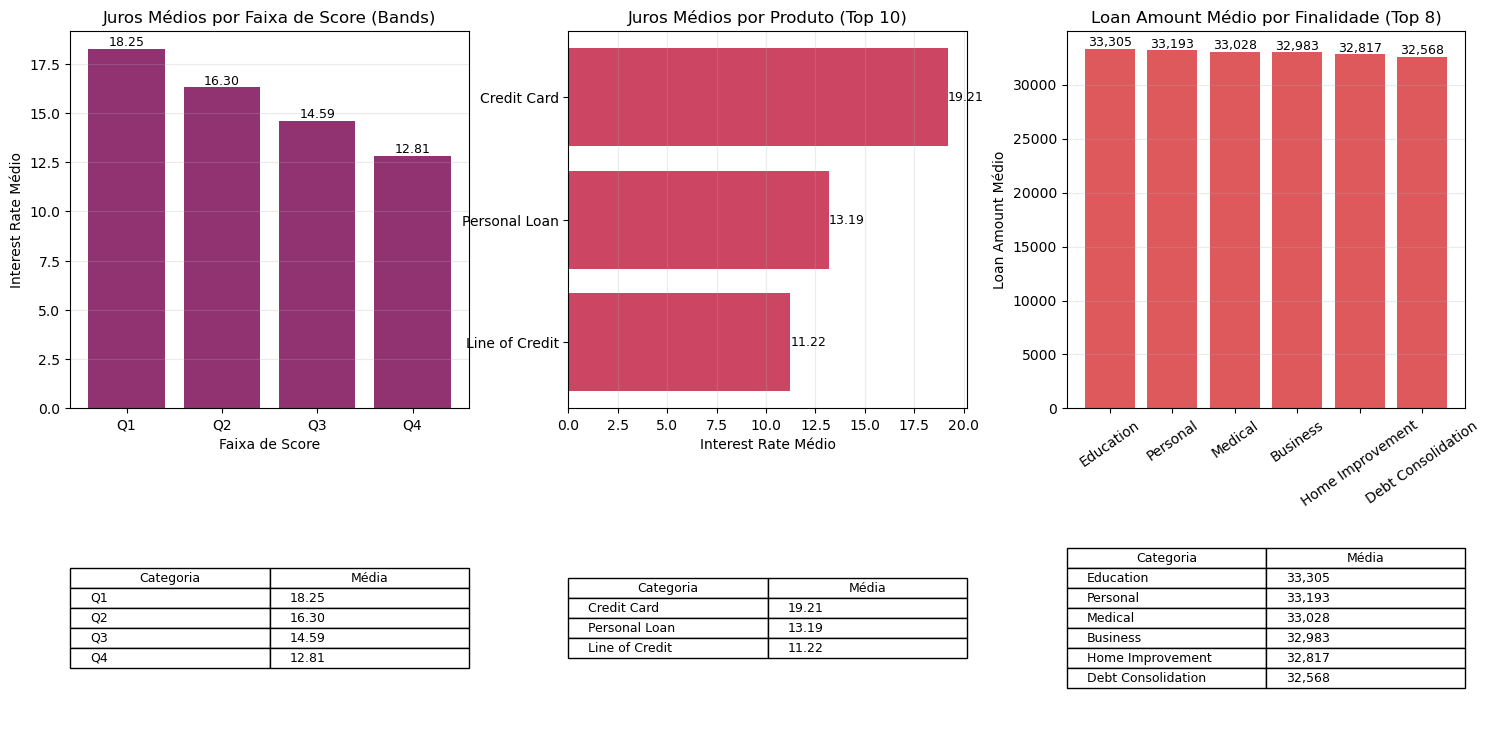

,Métrica,Valor
0,Slope (por 1 ponto de score),-0.030993
1,Δ taxa por +100 pts de score,-3.099
2,R² (linear),0.243
3,p-valor (slope),< 0.001
4,Intercept,35.446


In [44]:
juros_faixa, juros_prod, loan_intent = painel_etapa4(df, top_n_produto=10, top_n_intent=8)
tabela_elasticidade_score_juros(df)

---

## 📊 O sistema está precificando risco?

Sim.

A taxa de juros diminui de forma consistente conforme o credit score aumenta:

* Q1 (menor score): **18.25**
* Q4 (maior score): **12.81**

A diferença entre os extremos é de aproximadamente **5,4 p.p.**

A regressão linear confirma a relação:

* **Δ ≈ -3,10 p.p. a cada +100 pontos de score**
* **R² = 0,243**
* **p-valor < 0,001**

Além disso, produtos diferentes apresentam níveis distintos de taxa, indicando que a estrutura do crédito também influencia a precificação.

---

## ✅ Conclusão

O sistema demonstra coerência econômica:

* Score menor → juros maiores
* Score maior → juros menores
* A variação é estatisticamente significativa

Em termos práticos, o preço do crédito está alinhado ao risco do tomador.

---


# Etapa 5 — Resultado Final: O que determina o loan_status

## 5.1 — Distribuição do Target e Indicadores-Chave

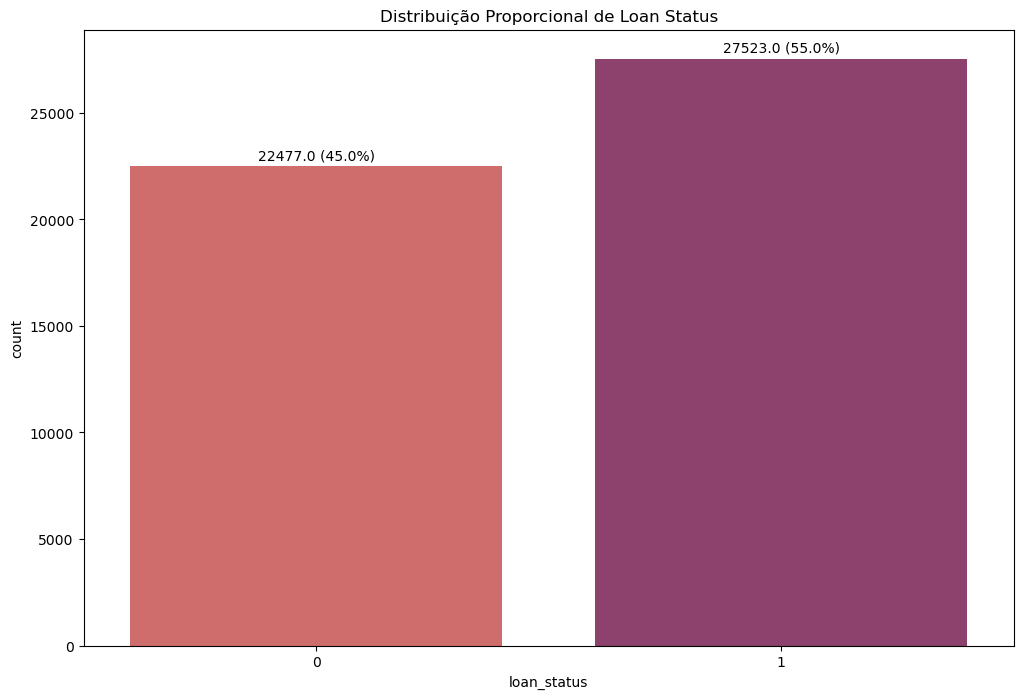

In [45]:
plt.figure(figsize=(12, 8))


ax = sns.countplot(data=df, x='loan_status', hue='loan_status', palette='flare', legend=False)


total = len(df['loan_status'])


for container in ax.containers:
    labels = [f'{v.get_height()} ({v.get_height()/total:.1%})' for v in container]
    ax.bar_label(container, labels=labels, padding=3)

plt.title('Distribuição Proporcional de Loan Status')
plt.show()

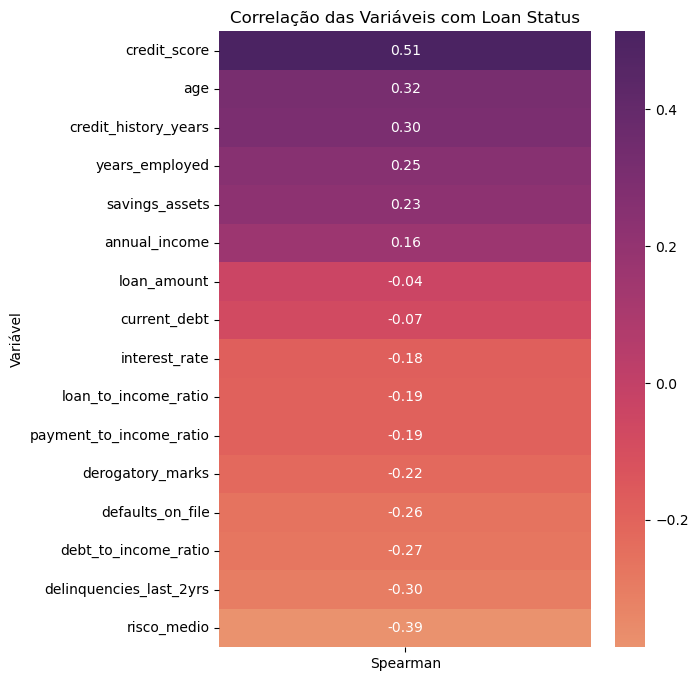

,Spearman,p_valor
Variável,,
credit_score,0.513930,0.000000e+00
age,0.315681,0.000000e+00
credit_history_years,0.302691,0.000000e+00
years_employed,0.247544,0.000000e+00
savings_assets,0.228251,0.000000e+00
annual_income,0.161875,1.145490e-290
loan_amount,-0.039839,5.028981e-19
current_debt,-0.074072,8.896472e-62
interest_rate,-0.175818,0.000000e+00


In [46]:
def correlacao_com_target(df, target='loan_status'):

    variaveis_numericas = df.select_dtypes(include=['int64','float64']).columns
    variaveis_numericas = [v for v in variaveis_numericas if v != target]

    resultados = []

    for var in variaveis_numericas:
        corr, p = spearmanr(df[var], df[target])
        resultados.append({
            'Variável': var,
            'Spearman': corr,
            'p_valor': p
        })

    corr_df = pd.DataFrame(resultados).set_index('Variável')
    corr_df = corr_df.sort_values('Spearman', ascending=False)

    plt.figure(figsize=(6,8))
    sns.heatmap(
        corr_df[['Spearman']],
        annot=True,
        cmap='flare',
        center=0,
        fmt=".2f"
    )
    plt.title('Correlação das Variáveis com Loan Status')
    plt.show()

    return corr_df

corr_target = correlacao_com_target(df)
corr_target

Claro — aqui vai uma versão **bem mais curta e “business”**, pronta pra colar no notebook.

---

## 5.1 — Visão do Target e Sinais Iniciais

**Distribuição do `loan_status`**
O target está bem balanceado (**45% classe 0 vs 55% classe 1**), o que é positivo para a modelagem e reduz viés por desbalanceamento. As métricas principais na etapa 6 serão **ROC-AUC**, **F1** e **matriz de confusão**.

**Principais sinais (Spearman vs `loan_status`)**
As variáveis com maior capacidade de discriminar o status do empréstimo são:

* **Qualidade de crédito:** `credit_score` (**0.51**)
* **Risco histórico:** `risco_medio` (**-0.39**), `delinquencies_last_2yrs` (**-0.30**), `defaults_on_file` (**-0.26**)
* **Capacidade financeira:** `debt_to_income_ratio` (**-0.27**)
* **Perfil/estabilidade:** `age` (**0.32**), `credit_history_years` (**0.30**), `years_employed` (**0.25**)

Já `loan_amount` (**-0.04**) e `current_debt` (**-0.07**) têm baixo poder explicativo isoladamente.

**Conclusão**
O dataset tem **bom equilíbrio de classes** e **sinal forte** nas dimensões de **score**, **histórico negativo** e **DTI**. A próxima etapa (5.2) vai quantificar isso em **taxas por faixas** e identificar **limiares críticos** antes da modelagem.

> Observação: na etapa 6, vale testar **com e sem `interest_rate`** para evitar possível *leakage* (taxa pode ser definida após a decisão em cenários reais).

---

Se quiser, eu reduzo ainda mais para **3–4 linhas** (versão “executiva de slide”).


## 5.2 — Drivers do loan_status: análise por classe (0 vs 1)

In [47]:
def plot_feature_vs_target(
    df,
    feature,
    target="loan_status",
    palette="flare",
    cap_quantiles=(0.01, 0.99), 
    show_fliers=False,
    figsize=(12, 6),
    title_prefix=None
):
    df_plot = df.copy()

    df_plot[target] = pd.to_numeric(df_plot[target], errors="coerce")
    df_plot[feature] = pd.to_numeric(df_plot[feature], errors="coerce")

    df_plot = df_plot.dropna(subset=[target, feature])

    order = sorted(df_plot[target].unique())

    plot_col = feature
    if cap_quantiles is not None:
        q_low, q_high = df_plot[feature].quantile(cap_quantiles)
        plot_col = f"{feature}_cap"
        df_plot[plot_col] = df_plot[feature].clip(q_low, q_high)

    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(nrows=2, ncols=2, height_ratios=[3, 1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax_tbl = fig.add_subplot(gs[1, :])

    sns.violinplot(
        data=df_plot, x=target, y=plot_col,
        hue=target, palette=palette,
        order=order, inner="quartile", cut=0,
        dodge=False, ax=ax1
    )
    ax1.set_title(f"{feature} vs {target} (Violin + Quartis)")
    ax1.set_xlabel(target)
    ax1.set_ylabel(feature)
    leg = ax1.get_legend()
    if leg: leg.remove()

    sns.boxplot(
        data=df_plot, x=target, y=plot_col,
        hue=target, palette=palette,
        order=order, showfliers=show_fliers,
        dodge=False, ax=ax2
    )

    medians = df_plot.groupby(target)[plot_col].median().reindex(order)
    ax2.scatter(range(len(order)), medians.values, s=80, zorder=3, label="Mediana")
    for i, v in enumerate(medians.values):
        ax2.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    ax2.set_title(f"{feature} vs {target} (Boxplot + Medianas)")
    ax2.set_xlabel(target)
    ax2.set_ylabel(feature)
    leg = ax2.get_legend()
    if leg: leg.remove()

    summary = (
        df_plot.groupby(target)[feature]
        .agg(
            n="count",
            mean="mean",
            median="median",
            q1=lambda x: x.quantile(0.25),
            q3=lambda x: x.quantile(0.75)
        )
    )
    summary["iqr"] = summary["q3"] - summary["q1"]
    summary = summary.reindex(order)

    # Diferença de medianas (1 - 0), se tiver 0 e 1
    diff_txt = ""
    if set([0, 1]).issubset(set(summary.index)):
        diff = summary.loc[1, "median"] - summary.loc[0, "median"]
        diff_txt = f"Δ mediana (1-0): {diff:.2f}"

    ax_tbl.axis("off")

    tbl_df = summary.copy()
    tbl_df[["mean","median","q1","q3","iqr"]] = tbl_df[["mean","median","q1","q3","iqr"]].round(2)

    table = ax_tbl.table(
        cellText=tbl_df.reset_index().values,
        colLabels=["loan_status","n","mean","median","q1","q3","iqr"],
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.2)

    main_title = f"{title_prefix} — {feature}" if title_prefix else f"{feature} vs {target}"
    fig.suptitle(f"{main_title}  |  {diff_txt}", y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

    return summary

In [90]:
def plot_features_dashboard(
    df,
    features,
    target="loan_status",
    palette="flare",
    cap_quantiles=(0.01, 0.99),
    show_fliers=False,
    figsize_per_feature=(12, 6),
    title_prefix="Drivers do loan_status"
):
    summaries = {}

    for feat in features:
        summaries[feat] = plot_feature_vs_target(
            df=df,
            feature=feat,
            target=target,
            palette=palette,
            cap_quantiles=cap_quantiles,
            show_fliers=show_fliers,
            figsize=figsize_per_feature,
            title_prefix=title_prefix
        )

    return summaries

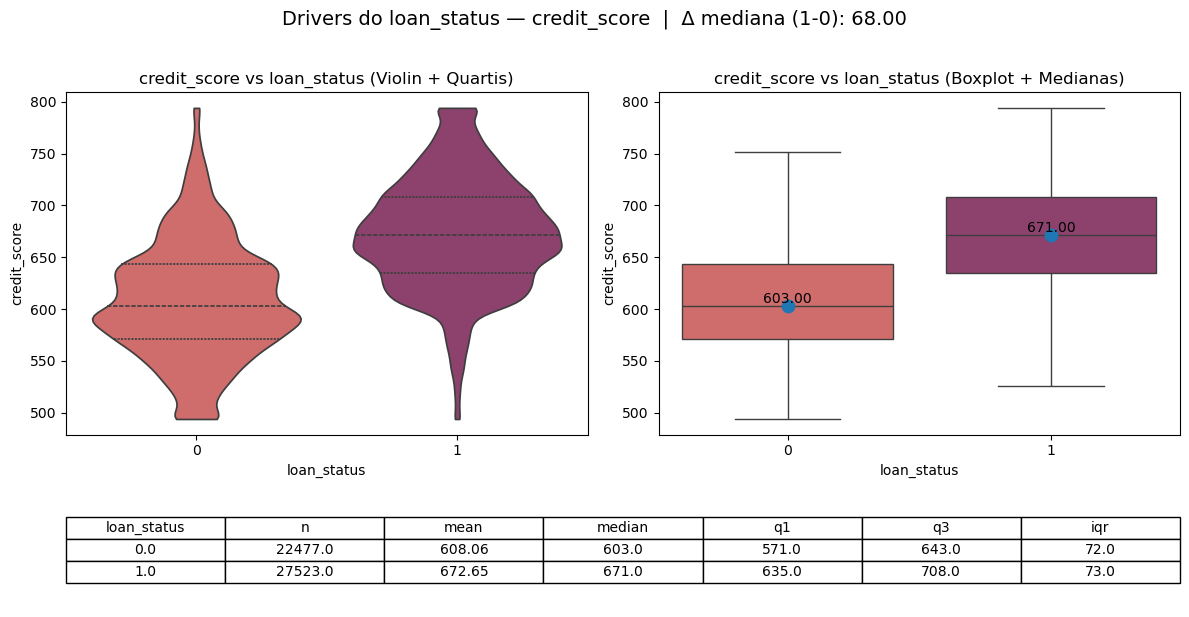

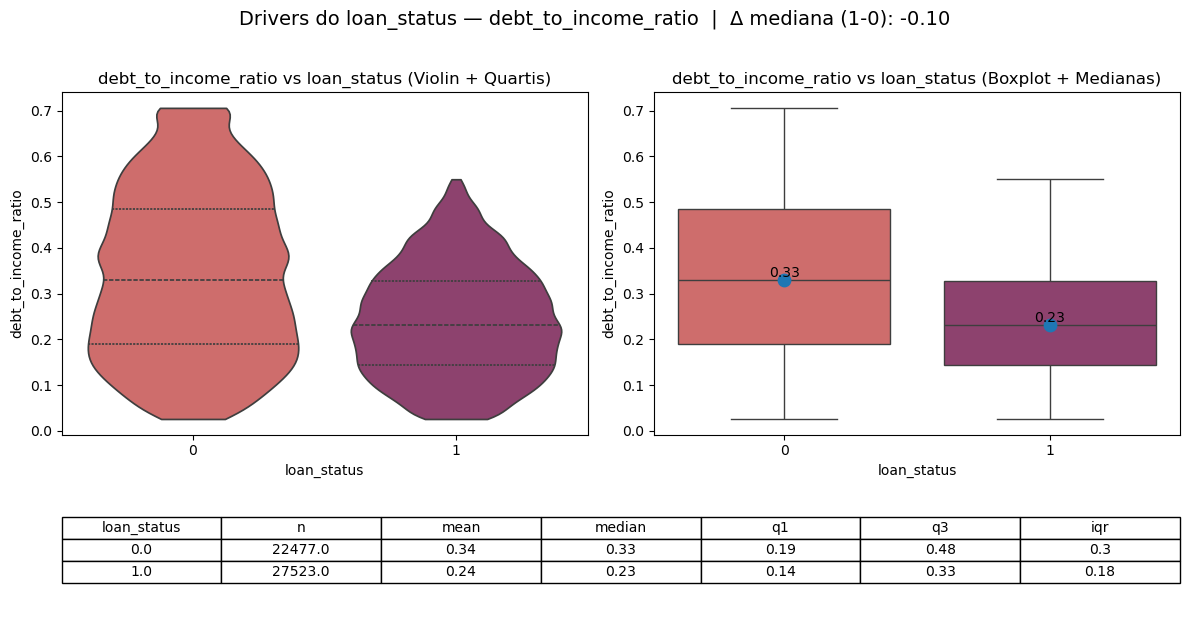

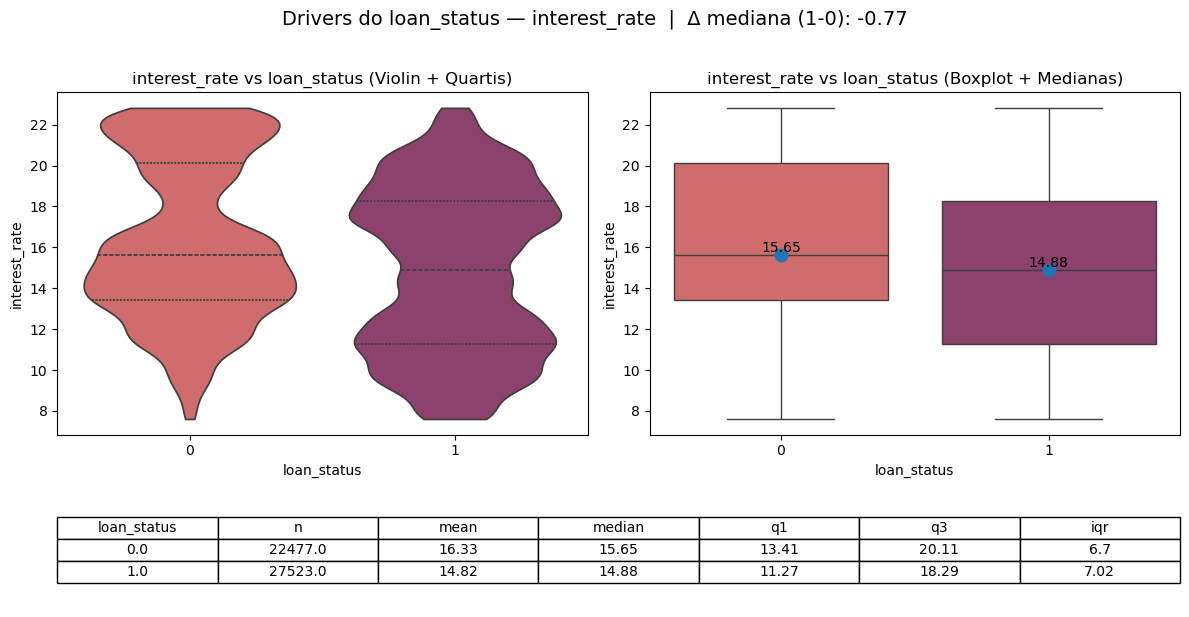

In [91]:
features_52 = [
    "credit_score",
    "debt_to_income_ratio",
    "interest_rate"
]

summaries = plot_features_dashboard(df, features_52, target="loan_status", palette="flare")

In [92]:
def plot_binary_feature_vs_target(df, feature, target="loan_status", palette="flare"):
    # 1) checagem de colunas
    missing = [c for c in [feature, target] if c not in df.columns]
    if missing:
        raise KeyError(
            f"Coluna(s) não encontrada(s): {missing}. "
            f"Colunas disponíveis (exemplo): {list(df.columns)[:15]} ..."
        )

    dfp = df[[feature, target]].copy()
    dfp[feature] = pd.to_numeric(dfp[feature], errors="coerce")
    dfp[target]  = pd.to_numeric(dfp[target], errors="coerce")
    dfp = dfp.dropna()

    # 2) checar se feature é binária
    vals = set(dfp[feature].unique())
    if not vals.issubset({0, 1}):
        raise ValueError(
            f"'{feature}' não é binária (0/1). Valores encontrados: {sorted(list(vals))[:10]}...\n"
            f"Sugestão: crie uma versão binária, ex:\n"
            f"df['{feature}_bin'] = (df['{feature}'] > 0).astype(int)\n"
            f"e rode: plot_binary_feature_vs_target(df, '{feature}_bin', target='{target}')"
        )

    dfp = dfp[dfp[target].isin([0, 1])]

    rate = (
        dfp.groupby(feature, observed=True)[target]
           .mean()
           .rename("approval_rate")
           .reset_index()
    )

    ctab = pd.crosstab(dfp[feature], dfp[target])

    p0 = rate.loc[rate[feature] == 0, "approval_rate"].values[0] if (rate[feature] == 0).any() else np.nan
    p1 = rate.loc[rate[feature] == 1, "approval_rate"].values[0] if (rate[feature] == 1).any() else np.nan
    lift = (p1 - p0) if (pd.notna(p0) and pd.notna(p1)) else np.nan

    a = ctab.loc[1, 1] if (1 in ctab.index and 1 in ctab.columns) else 0
    b = ctab.loc[1, 0] if (1 in ctab.index and 0 in ctab.columns) else 0
    c = ctab.loc[0, 1] if (0 in ctab.index and 1 in ctab.columns) else 0
    d = ctab.loc[0, 0] if (0 in ctab.index and 0 in ctab.columns) else 0
    or_value = ((a + 0.5) * (d + 0.5)) / ((b + 0.5) * (c + 0.5))

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(
        data=rate,
        x=feature,
        y="approval_rate",
        ax=ax,
        palette=palette,
        hue=feature,
        legend=False
    )

    ax.set_title(
        f"Taxa de aprovação (loan_status=1) por {feature} | "
        f"Lift (1-0): {lift:.3f} | Odds Ratio: {or_value:.2f}"
    )
    ax.set_xlabel(feature)
    ax.set_ylabel("Taxa de loan_status = 1")

    for i, row in rate.iterrows():
        ax.text(i, row["approval_rate"], f'{row["approval_rate"]*100:.1f}%', ha="center", va="bottom")

    plt.tight_layout()
    plt.show()

    display(rate)
    display(ctab)

    return rate, ctab, lift, or_value

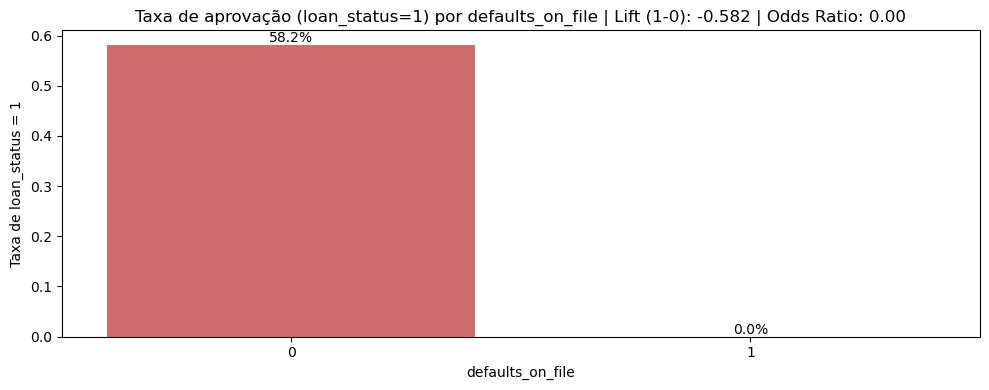

,defaults_on_file,approval_rate
0,0,0.581562
1,1,0.000000


loan_status,0,1
defaults_on_file,,
0,19803,27523
1,2674,0


(   defaults_on_file  approval_rate
 0                 0       0.581562
 1                 1       0.000000,
 loan_status           0      1
 defaults_on_file              
 0                 19803  27523
 1                  2674      0,
 np.float64(-0.58156193213033),
 np.float64(0.000134513444879814))

In [93]:
plot_binary_feature_vs_target(df, "defaults_on_file", target="loan_status")

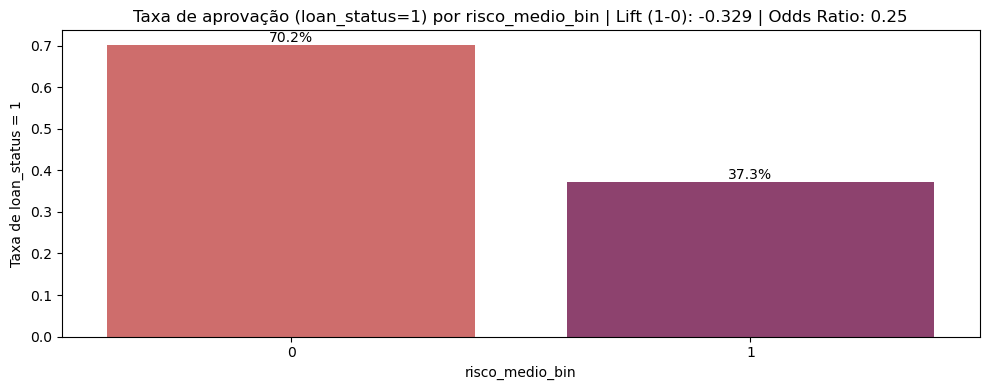

,risco_medio_bin,approval_rate
0,0,0.701750
1,1,0.372558


loan_status,0,1
risco_medio_bin,,
0,8059,18962
1,14418,8561


(   risco_medio_bin  approval_rate
 0                0       0.701750
 1                1       0.372558,
 loan_status          0      1
 risco_medio_bin              
 0                 8059  18962
 1                14418   8561,
 np.float64(-0.32919293781137154),
 np.float64(0.25237264831042133))

In [96]:
df['risco_medio_bin'] = (df['risco_medio'] > 0).astype(int)
plot_binary_feature_vs_target(df, 'risco_medio_bin', target='loan_status')

## 5.2 — Drivers do `loan_status` (0 vs 1)

Nesta etapa, avaliamos quais variáveis realmente **separam** as classes de `loan_status` e quais padrões explicam o resultado do empréstimo.

### `credit_score` (qualidade de crédito)
O score apresenta a **separação mais clara** entre as classes. Em termos práticos, quanto maior o score, **maior a probabilidade** de `loan_status=1`. É o driver mais consistente e tende a ser o principal sinal na modelagem.

---

### `debt_to_income_ratio` (capacidade de pagamento)
O DTI funciona como um indicador direto de capacidade: perfis com maior comprometimento de renda com dívidas tendem a apresentar **pior desfecho**. Ele complementa o score porque captura risco de “aperto financeiro”, mesmo em clientes com score razoável.

---

### `defaults_on_file` (regra dura / veto)
A presença de default prévio se comporta como um **critério de veto** no dataset: quando ocorre, o resultado tende fortemente para a classe negativa. Por ser um sinal muito forte (quase determinístico), na modelagem vale comparar desempenho **com e sem** essa variável para checar robustez.

---

### `risco_medio` (histórico negativo agregado)
O risco agregado resume eventos negativos do passado e mostra impacto consistente no resultado. É útil para explicar o desfecho de forma “executiva” (um único indicador de risco), mas pode competir com as variáveis que o compõem — algo que será endereçado na etapa de modelagem.

---

### `interest_rate` (precificação de risco)
A taxa de juros aparece alinhada ao risco: perfis piores tendem a receber condições mais caras, sugerindo **precificação**. Como juros pode ser definido após a decisão em cenários reais, também será testado **com/sem** na modelagem para evitar possível *leakage*.

---

### Síntese (5.2)
Os resultados indicam que o `loan_status` é explicado principalmente por três eixos: **qualidade de crédito (score)**, **capacidade financeira (DTI)** e **histórico negativo**. A taxa de juros reforça a lógica de precificação e será tratada com cautela na modelagem.

In [53]:
print(loan_approval_features['loan_status'])
print(loan_approval_features['defaults_on_file'])

Status do empréstimo ['Approved', 'Rejected', 'Fully Paid', 'Default', etc.]
Número de inadimplências registradas no histórico de crédito


## 5.3 — Limiar crítico e taxas por faixas (bins)

In [99]:
def plot_approval_rate_by_bins(
    df,
    feature,
    target="loan_status",
    q=5,
    palette="flare",
    rotate_xticks=25,
    title=None,
    show_table=True
):
    df_bins = df.copy()
    df_bins[target] = pd.to_numeric(df_bins[target], errors="coerce")
    df_bins[feature] = pd.to_numeric(df_bins[feature], errors="coerce")
    df_bins = df_bins.dropna(subset=[target, feature])

    bin_col = f"{feature}_bin"
    df_bins[bin_col] = pd.qcut(df_bins[feature], q=q, duplicates="drop")

    rate_df = (
        df_bins.groupby(bin_col, observed=False)[target]
        .agg(approval_rate="mean", n="count")
        .reset_index()
        .rename(columns={bin_col: "bin"})
    )
    rate_df["approval_pct"] = (rate_df["approval_rate"] * 100).round(1)

    plt.figure(figsize=(14, 8))
    ax = sns.barplot(data=rate_df, x="bin", y="approval_rate", hue="bin", palette=palette, legend=False)

    if title is None:
        title = f"Taxa de {target}=1 por faixas de {feature} (quantis)"
    plt.title(title)
    plt.xlabel(f"Faixa de {feature}")
    plt.ylabel(f"Taxa de {target} = 1")
    plt.xticks(rotation=rotate_xticks)

    for i, row in rate_df.iterrows():
        ax.text(
            i, row["approval_rate"],
            f'{row["approval_pct"]}%\n(n={row["n"]})',
            ha="center", va="bottom"
        )

    plt.tight_layout()
    plt.show()

    if show_table:
        display(rate_df)

    return rate_df

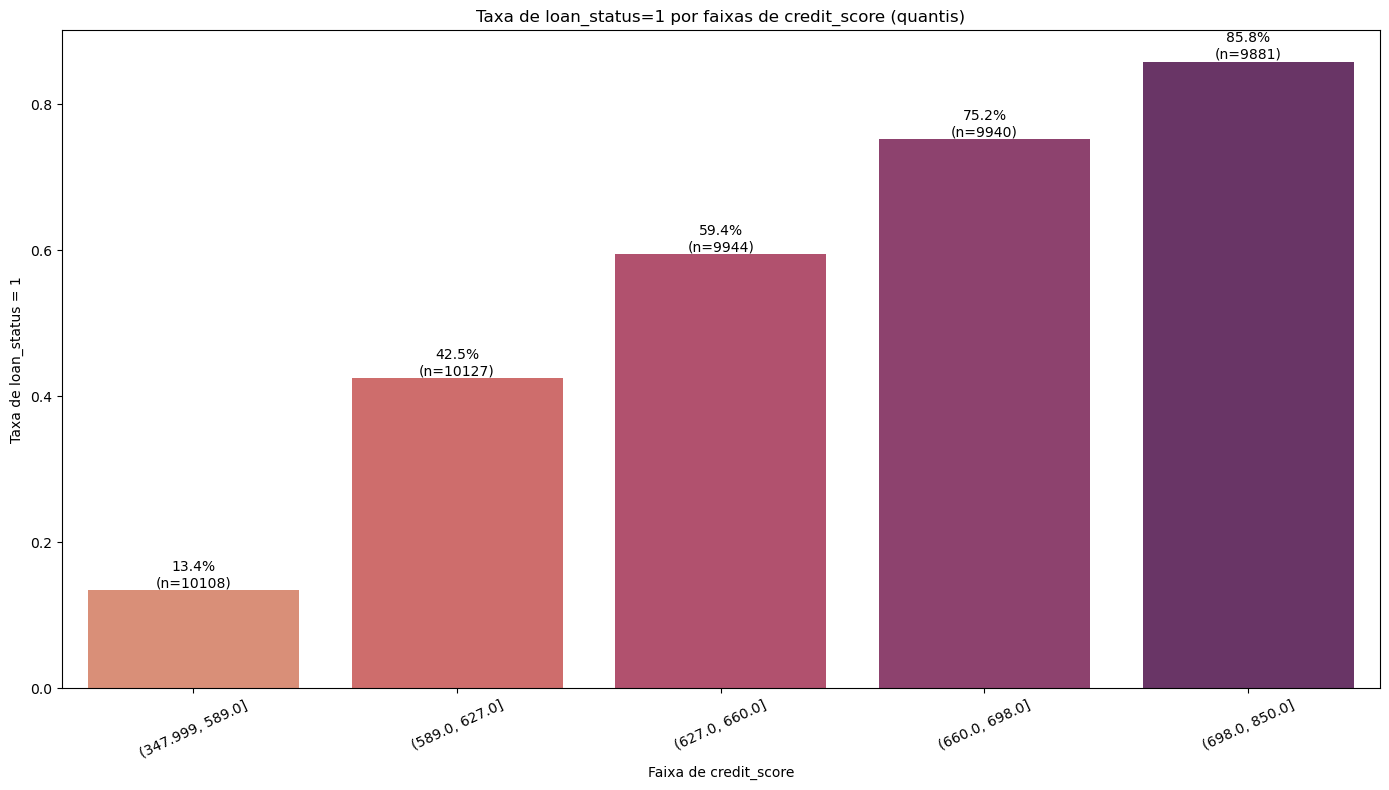

,bin,approval_rate,n,approval_pct
0,"(347.999, 589.0]",0.134448,10108,13.4
1,"(589.0, 627.0]",0.424805,10127,42.5
2,"(627.0, 660.0]",0.594328,9944,59.4
3,"(660.0, 698.0]",0.751811,9940,75.2
4,"(698.0, 850.0]",0.858112,9881,85.8


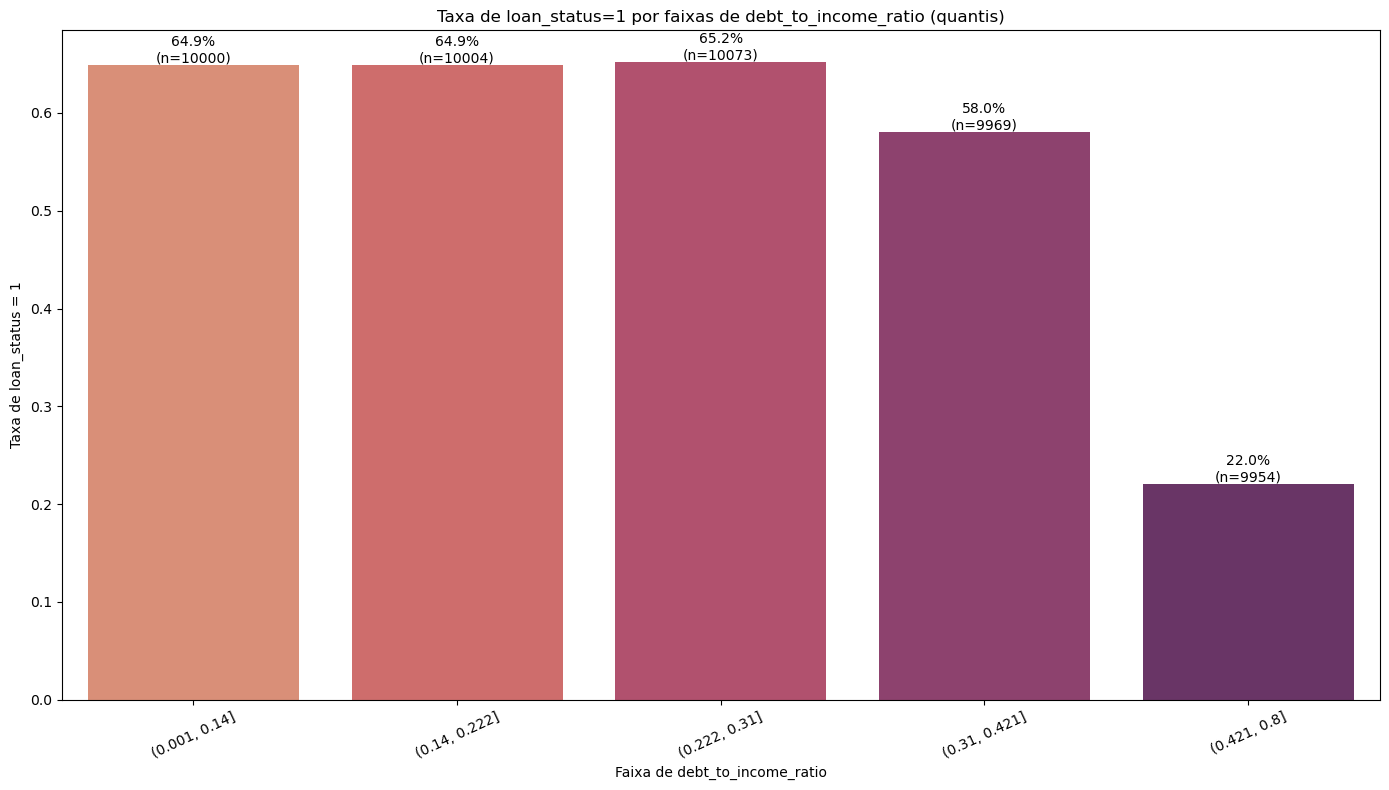

,bin,approval_rate,n,approval_pct
0,"(0.001, 0.14]",0.648700,10000,64.9
1,"(0.14, 0.222]",0.648641,10004,64.9
2,"(0.222, 0.31]",0.651941,10073,65.2
3,"(0.31, 0.421]",0.580500,9969,58.0
4,"(0.421, 0.8]",0.220313,9954,22.0


In [100]:
score_rate = plot_approval_rate_by_bins(df, "credit_score", target="loan_status", q=5)
dti_rate   = plot_approval_rate_by_bins(df, "debt_to_income_ratio", target="loan_status", q=5)

In [101]:
def plot_heatmap_rate_by_bins(
    df,
    feature_x,               
    feature_y,                
    target="loan_status",
    q=5,
    figsize=(14, 6),
    title=None,
    cbar_label=None,
    show_tables=True
):
    df_hm = df.copy()

    df_hm[target] = pd.to_numeric(df_hm[target], errors="coerce")
    df_hm[feature_x] = pd.to_numeric(df_hm[feature_x], errors="coerce")
    df_hm[feature_y] = pd.to_numeric(df_hm[feature_y], errors="coerce")
    df_hm = df_hm.dropna(subset=[target, feature_x, feature_y])

    x_bin = f"{feature_x}_bin"
    y_bin = f"{feature_y}_bin"
    df_hm[x_bin] = pd.qcut(df_hm[feature_x], q=q, duplicates="drop")
    df_hm[y_bin] = pd.qcut(df_hm[feature_y], q=q, duplicates="drop")

    pivot_rate = pd.pivot_table(
        df_hm,
        index=x_bin,
        columns=y_bin,
        values=target,
        aggfunc="mean",
        observed=False  
    )

    pivot_n = pd.pivot_table(
        df_hm,
        index=x_bin,
        columns=y_bin,
        values=target,
        aggfunc="size",
        observed=False 
    )

    plt.figure(figsize=figsize)
    if title is None:
        title = f"Taxa de {target}=1 por faixas de {feature_x} × {feature_y} (em %)"
    if cbar_label is None:
        cbar_label = f"Taxa de {target}=1"

    sns.heatmap(
        pivot_rate,
        annot=(pivot_rate * 100).round(1),
        fmt=".1f",
        cbar_kws={"label": cbar_label}
    )

    plt.title(title)
    plt.xlabel(f"Faixa de {feature_y}")
    plt.ylabel(f"Faixa de {feature_x}")
    plt.tight_layout()
    plt.show()

    if show_tables:
        display(pivot_rate)
        display(pivot_n)

    return pivot_rate, pivot_n

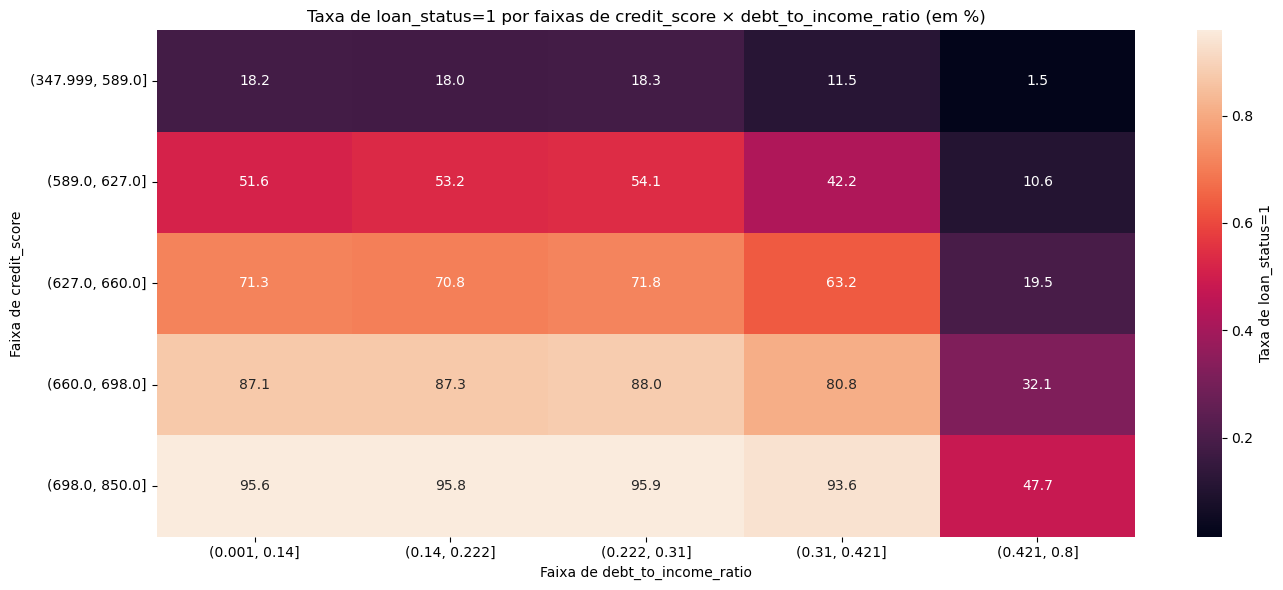

debt_to_income_ratio_bin,"(0.001, 0.14]","(0.14, 0.222]","(0.222, 0.31]","(0.31, 0.421]","(0.421, 0.8]"
credit_score_bin,,,,,
"(347.999, 589.0]",0.182276,0.179889,0.182785,0.115385,0.015437
"(589.0, 627.0]",0.515873,0.531852,0.540871,0.421640,0.106458
"(627.0, 660.0]",0.712620,0.708194,0.718466,0.632017,0.195147
"(660.0, 698.0]",0.871242,0.873008,0.879512,0.808479,0.320774
"(698.0, 850.0]",0.956136,0.958005,0.958768,0.935761,0.477261


debt_to_income_ratio_bin,"(0.001, 0.14]","(0.14, 0.222]","(0.222, 0.31]","(0.31, 0.421]","(0.421, 0.8]"
credit_score_bin,,,,,
"(347.999, 589.0]",1986,1979,2068,2002,2073
"(589.0, 627.0]",2016,2025,2043,2061,1982
"(627.0, 660.0]",1973,2087,1982,1924,1978
"(660.0, 698.0]",1996,2008,1967,2005,1964
"(698.0, 850.0]",2029,1905,2013,1977,1957


In [103]:
pivot_rate, pivot_n = plot_heatmap_rate_by_bins(
    df,
    feature_x="credit_score",
    feature_y="debt_to_income_ratio",
    target="loan_status",
    q=5
)

### Conclusão (5.3) — Limiar crítico e “zona de decisão” do `loan_status`

Ao transformar `credit_score` e `debt_to_income_ratio` (DTI) em faixas, identificamos **três achados-chave**:

1. **`credit_score` é o principal eixo de decisão:** a taxa de `loan_status=1` sobe de forma monotônica, saindo de **~13,4%** na menor faixa para **~85,8%** na maior, com um salto relevante a partir de **~589** e um patamar forte acima de **~660**.  
2. **DTI tem um limiar crítico claro:** até valores moderados as taxas se mantêm próximas, mas **acima de ~0,421** ocorre uma queda abrupta para **~22%**, caracterizando uma zona de baixa capacidade de pagamento.  
3. **Efeito combinado (policy):** o heatmap mostra que score alto ajuda muito quando o DTI é baixo/moderado, porém **DTI alto reduz fortemente a probabilidade** mesmo com score elevado (ex.: em score 698–850, a taxa cai para **~47,7%** quando DTI está na faixa mais alta).

**Resumo executivo:** o desfecho é explicado principalmente por **qualidade de crédito (score)** e **capacidade financeira (DTI)**, com limiares bem definidos. Esses insights orientam a próxima etapa, onde vamos treinar modelos para combinar múltiplos sinais e quantificar performance e importância das variáveis.

## 5.4 — Síntese executiva e ponte para modelagem

### Top 5 variáveis mais decisivas (até aqui)
Com base nas análises por classe (5.2) e nos limiares/zonas críticas (5.3), os sinais mais fortes para explicar o `loan_status` são:

1. **`credit_score`** — principal eixo de decisão (separação e thresholds claros).  
2. **`debt_to_income_ratio` (DTI)** — capacidade financeira; acima de um limiar crítico a taxa de `loan_status=1` despenca.  
3. **`defaults_on_file`** — comportamento de **regra dura/veto** no dataset (quase determinístico).  
4. **`risco_medio`** (agregado de histórico negativo) — reduz consistentemente a probabilidade de desfecho positivo.  
5. **`interest_rate`** — sinal alinhado a risco/precificação (taxas maiores em perfis piores).

---

### Hipótese final do negócio
O `loan_status` é determinado principalmente por **qualidade de crédito + capacidade financeira**, com reforço forte do **histórico negativo**:

- **Score** define o patamar base de risco.  
- **DTI** atua como fator limitante de capacidade (mesmo com bom score, DTI alto derruba o resultado).  
- **Eventos negativos** (`defaults_on_file` e/ou `risco_medio`) funcionam como penalidades severas — no caso de default prévio, pode atuar como veto.

---

### Ponte para modelagem (Etapa 6)
Agora o objetivo é **combinar todos os sinais simultaneamente** e quantificar performance preditiva com modelos supervisionados.

**Plano de modelagem:**
- Treinar baselines (ex.: **DummyClassifier** e **Logistic Regression**) e modelos não lineares (ex.: **RandomForest/GradientBoosting**).  
- Avaliar com **ROC-AUC**, **F1** e **matriz de confusão** (e **PR-AUC** se houver foco na classe minoritária).  
- Interpretar importância das variáveis (coeficientes / feature importance).

**Nota de qualidade (possível leakage):**
- Vamos treinar modelos **com e sem `interest_rate`** (e, se necessário, **com e sem `defaults_on_file`**) para garantir robustez e evitar dependência de variáveis que podem refletir decisões/políticas do processo.

# Etapa 6 Modelagem da loan status

In [107]:
df = pd.read_csv('Loan_approval_data_2025.csv')

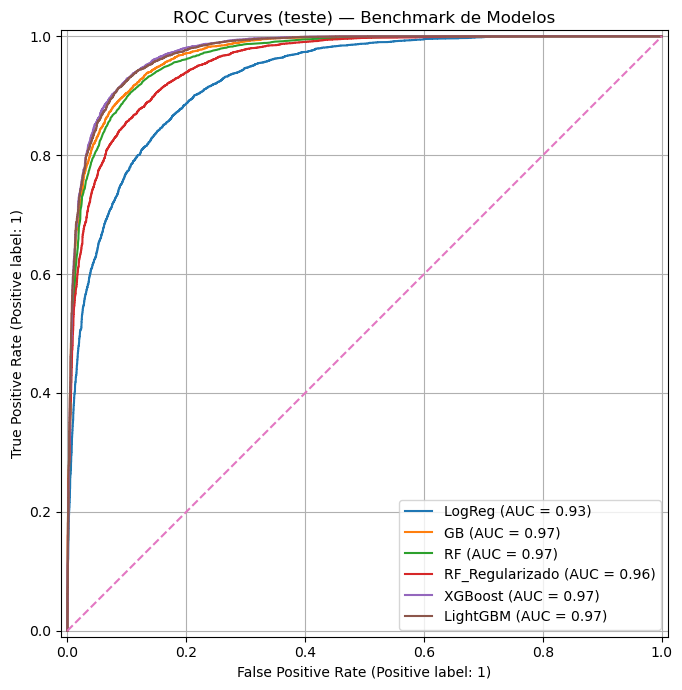

,model,cv_roc_auc_mean,cv_roc_auc_std,cv_pr_auc_mean,train_roc_auc_mean,test_roc_auc,test_pr_auc,gap_train_vs_cv,overfitting_flag
0,XGBoost,0.975000,0.001830,0.975915,0.984635,0.974185,0.975468,0.009635,não
1,LightGBM,0.973514,0.001860,0.974694,0.997057,0.973411,0.975229,0.023543,não
2,GB,0.970314,0.001984,0.971289,0.972849,0.969769,0.972272,0.002536,não
3,RF,0.964974,0.001703,0.967469,1.000000,0.965337,0.967923,0.035026,SIM
4,RF_Regularizado,0.954433,0.000735,0.958608,0.961620,0.955178,0.960455,0.007187,não
5,LogReg,0.929252,0.002610,0.935445,0.929510,0.928339,0.936821,0.000259,não


In [108]:

import warnings

warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but.*was fitted with feature names"
)

HAS_XGB = True
HAS_LGBM = True

from sklearn import set_config
set_config(transform_output="default")

try:
    from xgboost import XGBClassifier
except Exception:
    HAS_XGB = False

try:
    from lightgbm import LGBMClassifier
except Exception:
    HAS_LGBM = False


def build_preprocess(df, num_candidates, cat_candidates):
    num_cols = [c for c in num_candidates if c in df.columns]
    cat_cols = [c for c in cat_candidates if c in df.columns]
    cat_cols = list(dict.fromkeys(cat_cols))
    return num_cols, cat_cols


def make_pipe(model, num_cols, cat_cols, scale_num=False):
    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_num:
        num_steps.append(("scaler", StandardScaler()))
    num_pipe = Pipeline(steps=num_steps)

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols)
        ],
        remainder="drop"
    )

    return Pipeline(steps=[("preprocess", pre), ("model", model)])


def benchmark_models(
    csv_path="Loan_approval_data_2025.csv",
    target="loan_status",
    exclude_cols=("interest_rate", "defaults_on_file"),
    test_size=0.25,
    cv_splits=5,
    random_state=42,
    overfit_gap_threshold=0.03,
    plot_roc=True
):
    df = pd.read_csv(csv_path)
    df[target] = pd.to_numeric(df[target], errors="coerce")
    df = df.dropna(subset=[target])

    num_candidates = [
        "age","years_employed","annual_income","credit_score","credit_history_years",
        "savings_assets","current_debt","delinquencies_last_2yrs","derogatory_marks",
        "loan_amount","interest_rate","debt_to_income_ratio","loan_to_income_ratio","payment_to_income_ratio",
        "defaults_on_file"
    ]

    cat_candidates = [
        "ocupation_status", "occupation_status",
        "product_type", "loan_intent"
    ]

    exclude_cols = set(exclude_cols or [])
    num_candidates = [c for c in num_candidates if c not in exclude_cols]
    cat_candidates = [c for c in cat_candidates if c not in exclude_cols]

    num_cols, cat_cols = build_preprocess(df, num_candidates, cat_candidates)

    X = df[num_cols + cat_cols].copy()
    y = df[target].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    models = {
        "LogReg": LogisticRegression(max_iter=3000),
        "GB": GradientBoostingClassifier(random_state=random_state),
        "RF": RandomForestClassifier(
            n_estimators=400, random_state=random_state, n_jobs=-1
        ),
        "RF_Regularizado": RandomForestClassifier(
            n_estimators=600, random_state=random_state, n_jobs=-1,
            max_depth=8, min_samples_leaf=20, max_features="sqrt"
        ),
    }

    # XGBoost
    if HAS_XGB:
        models["XGBoost"] = XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            reg_alpha=0.0,
            eval_metric="logloss",
            random_state=random_state,
            n_jobs=-1
        )
    else:
        print("⚠️ XGBoost não está instalado. Rode: !pip install xgboost")

    if HAS_LGBM:
        models["LightGBM"] = LGBMClassifier(
            n_estimators=800,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            random_state=random_state,
            n_jobs=-1,
            verbose=-1,           
            force_col_wise=True  
        )
    else:
        print("⚠️ LightGBM não está instalado. Rode: !pip install lightgbm")

    pipes = {}
    for name, model in models.items():
        scale = (name == "LogReg")
        pipes[name] = make_pipe(model, num_cols, cat_cols, scale_num=scale)

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    rows = []
    fitted_pipes = {} 

    for name, pipe in pipes.items():
        cv_out = cross_validate(
            pipe,
            X_train, y_train,
            cv=cv,
            scoring={"roc_auc":"roc_auc", "pr_auc":"average_precision"},
            return_train_score=True
        )

        pipe.fit(X_train, y_train)
        fitted_pipes[name] = pipe 

        proba_test = pipe.predict_proba(X_test)[:, 1]
        test_roc = roc_auc_score(y_test, proba_test)
        test_pr  = average_precision_score(y_test, proba_test)

        train_cv_roc = cv_out["train_roc_auc"].mean()
        val_cv_roc   = cv_out["test_roc_auc"].mean()
        gap = train_cv_roc - val_cv_roc

        rows.append({
            "model": name,
            "cv_roc_auc_mean": val_cv_roc,
            "cv_roc_auc_std": cv_out["test_roc_auc"].std(),
            "cv_pr_auc_mean": cv_out["test_pr_auc"].mean(),
            "train_roc_auc_mean": train_cv_roc,
            "test_roc_auc": test_roc,
            "test_pr_auc": test_pr,
            "gap_train_vs_cv": gap,
            "overfitting_flag": "SIM" if gap > overfit_gap_threshold else "não"
        })

    ranking = pd.DataFrame(rows).sort_values(
        ["test_roc_auc", "cv_roc_auc_mean"], ascending=False
    ).reset_index(drop=True)

    if plot_roc:
        plt.figure(figsize=(10, 7))
        ax = plt.gca()

        for name, pipe in fitted_pipes.items():
            RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax, name=name)

        ax.plot([0, 1], [0, 1], linestyle="--")
        ax.set_title("ROC Curves (teste) — Benchmark de Modelos")
        ax.grid(True)
        plt.tight_layout()
        plt.show()

    display(ranking)
    return ranking, pipes, (X_train, X_test, y_train, y_test), (num_cols, cat_cols)


ranking, pipes, data_splits, cols = benchmark_models(
    csv_path="Loan_approval_data_2025.csv",
    exclude_cols=("interest_rate", "defaults_on_file"),
    overfit_gap_threshold=0.03,
    plot_roc=True
)

In [109]:
def build_preprocess(df, num_candidates, cat_candidates):
    num_cols = [c for c in num_candidates if c in df.columns]
    cat_cols = [c for c in cat_candidates if c in df.columns]
    cat_cols = list(dict.fromkeys(cat_cols))
    return num_cols, cat_cols


def make_pipe(model, num_cols, cat_cols, scale_num=False):
    num_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_num:
        num_steps.append(("scaler", StandardScaler()))
    num_pipe = Pipeline(steps=num_steps)

    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore"))
    ])

    pre = ColumnTransformer(
        transformers=[
            ("num", num_pipe, num_cols),
            ("cat", cat_pipe, cat_cols)
        ],
        remainder="drop"
    )

    return Pipeline(steps=[("preprocess", pre), ("model", model)])


def train_final_pipeline(
    csv_path="Loan_approval_data_2025.csv",
    target="loan_status",
    exclude_cols=("interest_rate", "defaults_on_file"),
    test_size=0.25,
    random_state=42,
    cv_splits=5,
    winner="XGBoost",  
):

    df = pd.read_csv(csv_path)
    df[target] = pd.to_numeric(df[target], errors="coerce")
    df = df.dropna(subset=[target])


    num_candidates = [
        "age","years_employed","annual_income","credit_score","credit_history_years",
        "savings_assets","current_debt","delinquencies_last_2yrs","derogatory_marks",
        "loan_amount","interest_rate","debt_to_income_ratio","loan_to_income_ratio","payment_to_income_ratio",
        "defaults_on_file"
    ]
    cat_candidates = ["ocupation_status","occupation_status","product_type","loan_intent"]


    exclude_cols = set(exclude_cols or [])
    num_candidates = [c for c in num_candidates if c not in exclude_cols]
    cat_candidates = [c for c in cat_candidates if c not in exclude_cols]

    num_cols, cat_cols = build_preprocess(df, num_candidates, cat_candidates)

    X = df[num_cols + cat_cols].copy()
    y = df[target].astype(int)


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )


    if winner.upper() == "XGBOOST":
        if not HAS_XGB:
            print("⚠️ XGBoost não está instalado. Usando GradientBoosting como fallback.")
            model = GradientBoostingClassifier(random_state=random_state)
            winner_used = "GB_fallback"
        else:
            model = XGBClassifier(
                n_estimators=800,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.9,
                colsample_bytree=0.9,
                reg_lambda=1.0,
                reg_alpha=0.0,
                eval_metric="logloss",
                random_state=random_state,
                n_jobs=-1
            )
            winner_used = "XGBoost"
        scale_num = False

    else:
        model = GradientBoostingClassifier(random_state=random_state)
        winner_used = "GB"
        scale_num = False

    pipe = make_pipe(model, num_cols, cat_cols, scale_num=scale_num)


    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    cv_out = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring={"roc_auc":"roc_auc", "pr_auc":"average_precision"},
        return_train_score=True
    )


    pipe.fit(X_train, y_train)

    proba_train = pipe.predict_proba(X_train)[:, 1]
    proba_test  = pipe.predict_proba(X_test)[:, 1]

    metrics = {
        "winner_used": winner_used,
        "excluded_cols": list(exclude_cols),
        "num_cols_used": num_cols,
        "cat_cols_used": cat_cols,
        "roc_auc_train": float(roc_auc_score(y_train, proba_train)),
        "roc_auc_test":  float(roc_auc_score(y_test,  proba_test)),
        "pr_auc_train":  float(average_precision_score(y_train, proba_train)),
        "pr_auc_test":   float(average_precision_score(y_test,  proba_test)),
        "cv_roc_auc_train_mean": float(cv_out["train_roc_auc"].mean()),
        "cv_roc_auc_val_mean":   float(cv_out["test_roc_auc"].mean()),
        "cv_pr_auc_train_mean":  float(cv_out["train_pr_auc"].mean()),
        "cv_pr_auc_val_mean":    float(cv_out["test_pr_auc"].mean()),
    }

    metrics["gap_train_test_roc"] = metrics["roc_auc_train"] - metrics["roc_auc_test"]
    metrics["gap_train_val_roc"]  = metrics["cv_roc_auc_train_mean"] - metrics["cv_roc_auc_val_mean"]

    return pipe, metrics


def save_artifacts(pipe, metrics, out_path="loan_model_pipeline.joblib"):
    """
    Salva um único arquivo .joblib contendo:
    - pipeline treinado
    - métricas (dict)
    """
    bundle = {
        "pipeline": pipe,
        "metrics": metrics
    }
    joblib.dump(bundle, out_path)
    print(f"✅ Salvo em: {out_path}")
    return out_path




pipe_final, metrics_final = train_final_pipeline(
    csv_path="Loan_approval_data_2025.csv",
    exclude_cols=("interest_rate", "defaults_on_file"),  
    winner="XGBoost",  
    test_size=0.25,
    random_state=42,
    cv_splits=5
)

print("\n=== Métricas finais ===")
for k, v in metrics_final.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

model_file = save_artifacts(pipe_final, metrics_final, out_path="loan_model_pipeline.joblib")


=== Métricas finais ===
winner_used: XGBoost
excluded_cols: ['defaults_on_file', 'interest_rate']
num_cols_used: ['age', 'years_employed', 'annual_income', 'credit_score', 'credit_history_years', 'savings_assets', 'current_debt', 'delinquencies_last_2yrs', 'derogatory_marks', 'loan_amount', 'debt_to_income_ratio', 'loan_to_income_ratio', 'payment_to_income_ratio']
cat_cols_used: ['occupation_status', 'product_type', 'loan_intent']
roc_auc_train: 0.9855
roc_auc_test: 0.9741
pr_auc_train: 0.9863
pr_auc_test: 0.9754
cv_roc_auc_train_mean: 0.9872
cv_roc_auc_val_mean: 0.9749
cv_pr_auc_train_mean: 0.9879
cv_pr_auc_val_mean: 0.9759
gap_train_test_roc: 0.0114
gap_train_val_roc: 0.0122
✅ Salvo em: loan_model_pipeline.joblib


Melhor threshold (por custo): 0.89
Custo mínimo: 2973.00
TN, FP, FN, TP: (np.int64(5501), np.int64(118), np.int64(1793), np.int64(5088))

=== Métricas no teste (threshold=0.89) ===
ROC-AUC: 0.9741
PR-AUC : 0.9754
Precision (classe 1): 0.9773
Recall    (classe 1): 0.7394
F1-score  (classe 1): 0.8419

=== Classification report ===
              precision    recall  f1-score   support

           0     0.7542    0.9790    0.8520      5619
           1     0.9773    0.7394    0.8419      6881

    accuracy                         0.8471     12500
   macro avg     0.8658    0.8592    0.8470     12500
weighted avg     0.8770    0.8471    0.8464     12500


=== Leitura de negócio (classe 1 = aprovado) ===
TN=5501: reais 0 previstos 0 (acertos na classe 0)
FP=118: reais 0 previstos 1 (falsos positivos — aprovar quando era 0)
FN=1793: reais 1 previstos 0 (falsos negativos — negar quando era 1)
TP=5088: reais 1 previstos 1 (acertos na classe 1)


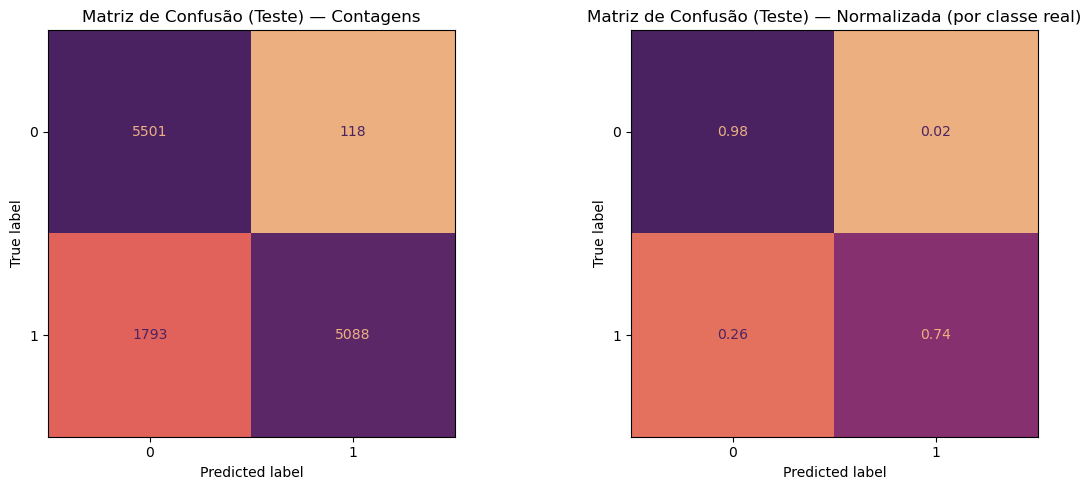

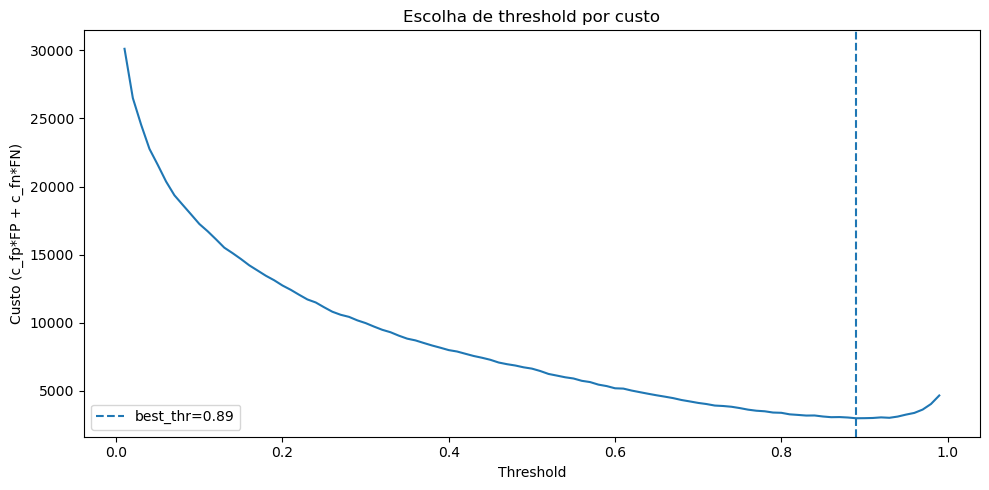

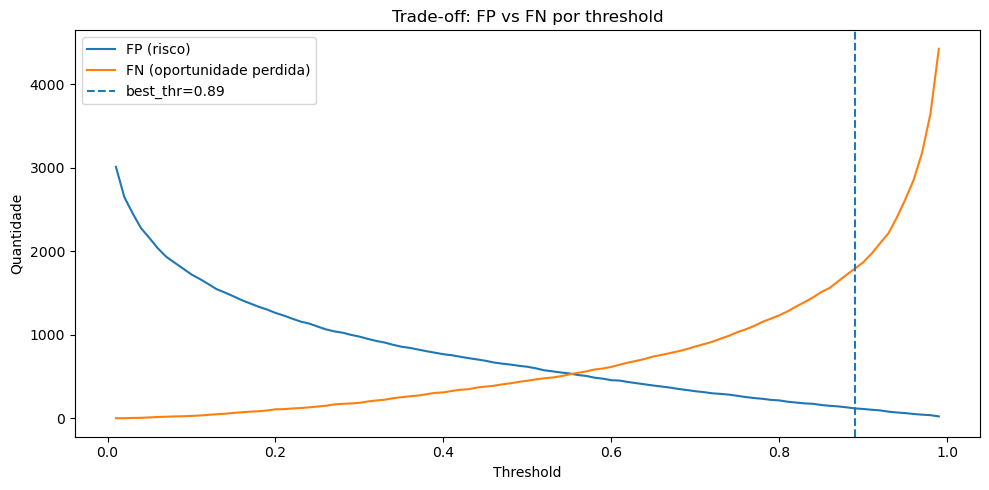

(0.89,
 (np.int64(5501), np.int64(118), np.int64(1793), np.int64(5088)),
 {'roc_auc': 0.9741488274246717,
  'pr_auc': 0.9753584745885849,
  'precision_1': 0.9773338455628121,
  'recall_1': 0.7394274088068594,
  'f1_1': 0.8418962521717548})

In [117]:
bundle = joblib.load("loan_model_pipeline.joblib")
pipe = bundle["pipeline"]
meta = bundle["metrics"]

num_cols = meta["num_cols_used"]
cat_cols = meta["cat_cols_used"]
def avaliar_modelo_com_threshold_por_custo(
    pipe,
    df,
    target="loan_status",
    num_cols=None,
    cat_cols=None,
    test_size=0.25,
    random_state=42,
    c_fp=10,
    c_fn=1,
    thresholds=None,
    cmap_name="flare",
    plot=True,
    verbose=True
):


    if num_cols is None or cat_cols is None:
        raise ValueError("Passe num_cols e cat_cols (listas). Ex: num_cols=..., cat_cols=...")

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    df_local = df.copy()
    df_local[target] = pd.to_numeric(df_local[target], errors="coerce")
    df_local = df_local.dropna(subset=[target])

    X = df_local[num_cols + cat_cols].copy()
    y = df_local[target].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )


    proba_test = pipe.predict_proba(X_test)[:, 1]


    costs, fps, fns = [], [], []
    best_thr = 0.50
    best_cost = float("inf")
    best_cm = None

    for thr in thresholds:
        y_tmp = (proba_test >= thr).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_tmp, labels=[0, 1]).ravel()
        cost = c_fp * fp + c_fn * fn

        costs.append(cost)
        fps.append(fp)
        fns.append(fn)

        if cost < best_cost:
            best_cost = cost
            best_thr = thr
            best_cm = (tn, fp, fn, tp)


    y_pred = (proba_test >= best_thr).astype(int)


    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    cm_norm = cm / cm.sum(axis=1, keepdims=True)

    roc = roc_auc_score(y_test, proba_test)
    pr = average_precision_score(y_test, proba_test)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    if verbose:
        print(f"Melhor threshold (por custo): {best_thr:.2f}")
        print(f"Custo mínimo: {best_cost:.2f}")
        print(f"TN, FP, FN, TP: {best_cm}")

        print(f"\n=== Métricas no teste (threshold={best_thr:.2f}) ===")
        print(f"ROC-AUC: {roc:.4f}")
        print(f"PR-AUC : {pr:.4f}")
        print(f"Precision (classe 1): {prec:.4f}")
        print(f"Recall    (classe 1): {rec:.4f}")
        print(f"F1-score  (classe 1): {f1:.4f}")

        print("\n=== Classification report ===")
        print(classification_report(y_test, y_pred, digits=4, zero_division=0))

        tn, fp, fn, tp = cm.ravel()
        print("\n=== Leitura de negócio (classe 1 = aprovado) ===")
        print(f"TN={tn}: reais 0 previstos 0 (acertos na classe 0)")
        print(f"FP={fp}: reais 0 previstos 1 (falsos positivos — aprovar quando era 0)")
        print(f"FN={fn}: reais 1 previstos 0 (falsos negativos — negar quando era 1)")
        print(f"TP={tp}: reais 1 previstos 1 (acertos na classe 1)")

    if plot:
        flare_cmap = sns.color_palette(cmap_name, as_cmap=True)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp1.plot(ax=axes[0], values_format="d", colorbar=False, cmap=flare_cmap)
        axes[0].set_title("Matriz de Confusão (Teste) — Contagens")

        disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])
        disp2.plot(ax=axes[1], values_format=".2f", colorbar=False, cmap=flare_cmap)
        axes[1].set_title("Matriz de Confusão (Teste) — Normalizada (por classe real)")

        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(thresholds, costs)
        plt.axvline(best_thr, linestyle="--", label=f"best_thr={best_thr:.2f}")
        plt.xlabel("Threshold")
        plt.ylabel("Custo (c_fp*FP + c_fn*FN)")
        plt.title("Escolha de threshold por custo")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Trade-off FP vs FN
        plt.figure(figsize=(10, 5))
        plt.plot(thresholds, fps, label="FP (risco)")
        plt.plot(thresholds, fns, label="FN (oportunidade perdida)")
        plt.axvline(best_thr, linestyle="--", label=f"best_thr={best_thr:.2f}")
        plt.xlabel("Threshold")
        plt.ylabel("Quantidade")
        plt.title("Trade-off: FP vs FN por threshold")
        plt.legend()
        plt.tight_layout()
        plt.show()

    return {
        "best_thr": float(best_thr),
        "best_cost": float(best_cost),
        "best_cm": best_cm,  
        "confusion_matrix": cm,
        "metrics": {
            "roc_auc": float(roc),
            "pr_auc": float(pr),
            "precision_1": float(prec),
            "recall_1": float(rec),
            "f1_1": float(f1),
        },
        "sweep": {
            "thresholds": np.array(thresholds),
            "costs": np.array(costs),
            "fps": np.array(fps),
            "fns": np.array(fns),
        },
        "data_split": {
            "X_test": X_test,
            "y_test": y_test,
            "proba_test": proba_test,
            "y_pred": y_pred,
        }
    }
res = avaliar_modelo_com_threshold_por_custo(
    pipe=pipe,
    df=df,
    target="loan_status",
    num_cols=num_cols,
    cat_cols=cat_cols,
    c_fp=10,
    c_fn=1,
    plot=True,
    verbose=True
)

res["best_thr"], res["best_cm"], res["metrics"]

---

## Conclusão executiva

Este projeto foi estruturado em **5 etapas de EDA** — **perfil**, **risco**, **capacidade**, **produto** e análise do **desfecho (`loan_status`)** — para construir uma narrativa de crédito consistente antes da modelagem. Ao longo dessas etapas, a leitura de negócio convergiu para três mecanismos principais por trás da aprovação: **qualidade de crédito**, **capacidade de pagamento** e **sinais de risco comportamental**.

Na sequência, validamos se esses padrões **generalizam** por meio de um **benchmark de modelos de Machine Learning**, comparando desempenho, consistência em validação cruzada e risco de overfitting. Entre os modelos avaliados, **XGBoost** apresentou o melhor equilíbrio entre performance e generalização, com **LightGBM** muito próximo e **GradientBoosting** como baseline forte.

Para uma avaliação mais realista, adotamos um **cenário “limpo”**, removendo variáveis com alto risco de atalhos/leakage (`defaults_on_file` e `interest_rate`). Ainda assim, o modelo final manteve **alta performance** (ROC-AUC e PR-AUC elevados) e **gaps baixos** entre treino, validação e teste, indicando boa estabilidade.

Por fim, traduzimos o modelo para decisão operacional via **calibração de threshold**. Como `loan_status=1` representa **aprovação**, adotamos uma política **conservadora** (FP mais caro que FN), priorizando reduzir aprovações indevidas (**risco**) em troca de maior perda de oportunidade. A otimização por custo esperado levou ao threshold **0.89**, com **TN=5501, FP=118, FN=1793, TP=5088**. *(As métricas ROC-AUC/PR-AUC refletem a capacidade de ranqueamento do modelo e são independentes do threshold.)*

✅ **Em síntese:** o projeto conecta **storytelling (EDA)** e **validação (modelagem)**, entregando um pipeline robusto, métricas fortes e uma camada de decisão ajustável para diferentes políticas de risco.

---
